<h1 align="center"> Auto insurance - Predicting the total cost & the insurance premium of bodily injury claims - Data Exploration </h1>

In this notebook, our aim is to explore the dataset with the goal of predicting the total cost of third-party bodily injury claims and the insurance premium in subsequent steps.

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [160]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, MaxAbsScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, r2_score, mean_squared_error, mean_absolute_error, PredictionErrorDisplay
import scipy.stats
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OrdinalEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from xgboost import XGBRegressor
from category_encoders import CountEncoder, TargetEncoder
import tensorflow as tf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import shap


## Goal of the project : 
The objective of calculating an annual third-party premium (material + bodily) for the 36,311 contracts in the 2011 pricing dataset :
Indeed, we will determine the cost of third-party insurance for each contract on an annual basis. This premium is intended to cover material and bodily damages caused to third parties in the event of an accident where the insured party is at fault.


#### Step 1. Data cleaning

In [10]:
# Load the training dataset
training_data = pd.read_csv('training.csv', sep=';')

In [11]:
# Display the first rows of the training dataset to understand its structure
print("Training Dataset:")
training_data.head()

Training Dataset:


,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
1,200114978,2009,Male,C,Large,Employed,25,18,90,3,15080,0,L46,L,72.012883,365,1,0,0.0,0.0
2,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370,1,O38,O,39.550411,365,1,0,0.0,0.0
3,200115001,2009,Female,E,Large,Unemployed,42,11,150,0,39650,0,Q28,Q,169.529148,365,2,0,0.0,0.0
4,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600,1,L6,L,58.894688,365,1,0,0.0,0.0
5,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065,0,N4,N,109.631885,365,2,0,0.0,0.0


The training dataset contains:

100,000 unique insurance contracts for the years 2009 and 2010e:
Here is a description of each column in the dataset.

| Column     | Description                                                                  |
|------------|------------------------------------------------------------------------------|
| PolNum     | Contract number                                                              |
| CalYear    | Subscription year                                                            |
| Gender     | Gender of the vehicle driver                                                 |
| Type       | Type of car                                                                  |
| Category   | Car category                                                                 |
| Occupation | Driver's occupation                                                          |
| Age        | Driver's age                                                                 |
| Group1     | Car group                                                                    |
| Bonus      | Bonus-Malus (a discount or surcharge applied based on the claims history)   |
| Poldur     | Age of the insurance contract                                                |
| Value      | Value of the insured vehicle                                                 |
| Adind      | Indicator for material coverage                                              |
| SubGroup2  | Driver's home sub-region                                                     |
| Group2     | Driver's home region                                                         |
| Density    | Population density                                                           |
| Expdays    | Exposure (in days)                                                           |
| Numtppd    | Number of third-party material claims                                        |
| Numtpbi    | Number of third-party bodily injury claims                                   |
| Indtppd    | Total cost of third-party material claims                                    |
| Indtpbi    | Total cost of third-party bodily injury claims                               |


In [12]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100021 entries, 1 to 100021
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PolNum      100021 non-null  int64  
 1   CalYear     100021 non-null  int64  
 2   Gender      100021 non-null  object 
 3   Type        100021 non-null  object 
 4   Category    100021 non-null  object 
 5   Occupation  100021 non-null  object 
 6   Age         100021 non-null  int64  
 7   Group1      100021 non-null  int64  
 8   Bonus       100021 non-null  int64  
 9   Poldur      100021 non-null  int64  
 10  Value       100021 non-null  int64  
 11  Adind       100021 non-null  int64  
 12  SubGroup2   100021 non-null  object 
 13  Group2      100021 non-null  object 
 14  Density     100021 non-null  float64
 15  Exppdays    100021 non-null  int64  
 16  Numtppd     100021 non-null  int64  
 17  Numtpbi     100021 non-null  int64  
 18  Indtppd     100021 non-null  float64
 19  Indtpbi

In [13]:
# Check for missing values in the training dataset
print("\nMissing Values in Training Dataset:")
print(training_data.isnull().sum())


Missing Values in Training Dataset:
PolNum        0
CalYear       0
Gender        0
Type          0
Category      0
Occupation    0
Age           0
Group1        0
Bonus         0
Poldur        0
Value         0
Adind         0
SubGroup2     0
Group2        0
Density       0
Exppdays      0
Numtppd       0
Numtpbi       0
Indtppd       0
Indtpbi       0
dtype: int64


In [14]:
# Check for duplicates in the training dataset
print("\nDuplicates in Training Dataset:")
print(training_data.duplicated().sum())


Duplicates in Training Dataset:
0


In [15]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
count,1.000210e+05,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000
mean,2.002003e+08,2009.499895,41.122514,10.692625,-6.921646,5.470781,16454.675268,0.512142,117.159270,327.588007,0.147449,0.046790,106.135007,222.762829
std,6.217239e+04,0.500002,14.299349,4.687286,48.633165,4.591194,10506.742732,0.499855,79.500907,73.564636,0.436917,0.219546,444.949188,1859.422836
min,2.001149e+08,2009.000000,18.000000,1.000000,-50.000000,0.000000,1000.000000,0.000000,14.377142,91.000000,0.000000,0.000000,0.000000,0.000000
25%,2.001399e+08,2009.000000,30.000000,7.000000,-40.000000,1.000000,8380.000000,0.000000,50.625783,340.000000,0.000000,0.000000,0.000000,0.000000
50%,2.001649e+08,2009.000000,40.000000,11.000000,-30.000000,4.000000,14610.000000,1.000000,94.364623,365.000000,0.000000,0.000000,0.000000,0.000000
75%,2.002608e+08,2010.000000,51.000000,14.000000,10.000000,9.000000,22575.000000,1.000000,174.644525,365.000000,0.000000,0.000000,0.000000,0.000000
max,2.002858e+08,2010.000000,75.000000,20.000000,150.000000,15.000000,49995.000000,1.000000,297.385170,365.000000,7.000000,3.000000,12878.369910,69068.026292


In [16]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
PolNum,1.000000,0.972667,0.002485,0.004175,-0.005531,-0.003895,-0.003639,0.001764,0.008203,-0.000497,0.016106,0.001217,0.016711,0.007758
CalYear,0.972667,1.000000,0.001821,0.003681,-0.005003,-0.002544,-0.003861,0.001795,0.008755,-0.001047,0.016180,-0.000046,0.017064,0.007688
Age,0.002485,0.001821,1.000000,0.090973,-0.214690,0.050484,0.017842,0.203033,0.003174,0.000863,-0.162853,-0.097282,-0.137889,-0.054483
Group1,0.004175,0.003681,0.090973,1.000000,-0.022209,0.004490,0.231667,0.020505,0.004588,0.002743,0.091533,0.026548,0.059937,0.002907
Bonus,-0.005531,-0.005003,-0.214690,-0.022209,1.000000,-0.008891,-0.001229,-0.040354,-0.003643,-0.002402,0.236655,0.070457,0.140030,0.037060
Poldur,-0.003895,-0.002544,0.050484,0.004490,-0.008891,1.000000,0.002306,0.012535,-0.001056,0.000464,-0.043223,-0.007521,-0.031090,-0.004129
Value,-0.003639,-0.003861,0.017842,0.231667,-0.001229,0.002306,1.000000,0.007748,0.002325,-0.002056,0.023859,0.007637,0.015581,0.001563
Adind,0.001764,0.001795,0.203033,0.020505,-0.040354,0.012535,0.007748,1.000000,0.003019,0.001841,-0.052238,-0.039524,-0.059245,-0.020352
Density,0.008203,0.008755,0.003174,0.004588,-0.003643,-0.001056,0.002325,0.003019,1.000000,-0.003989,0.121018,0.026220,0.105476,0.021282
Exppdays,-0.000497,-0.001047,0.000863,0.002743,-0.002402,0.000464,-0.002056,0.001841,-0.003989,1.000000,0.074080,0.048895,0.054129,0.027526


<Axes: xlabel='Bonus', ylabel='Indtpbi'>

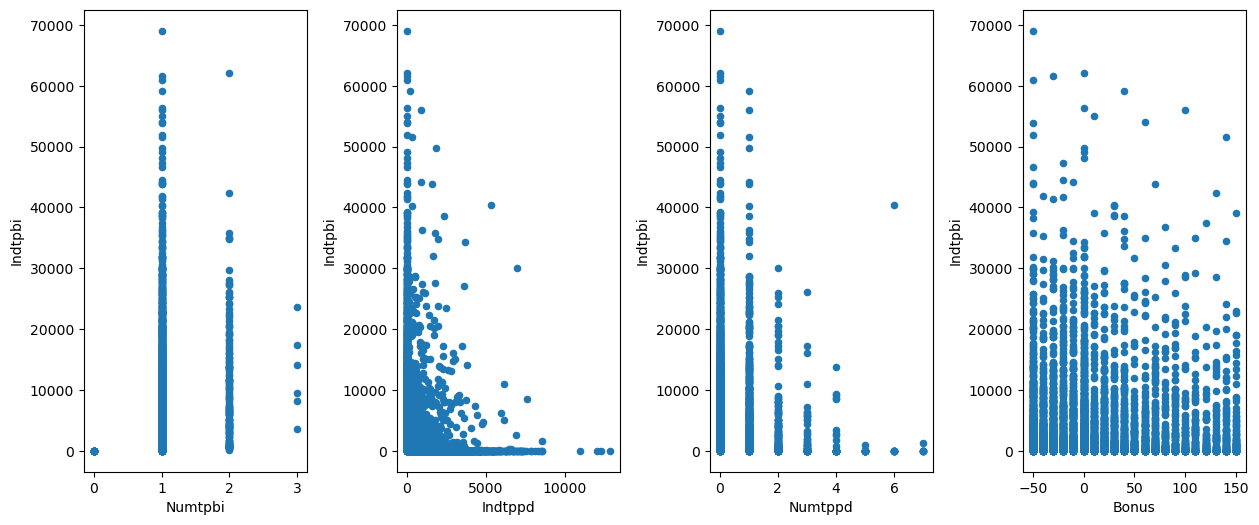

In [17]:
fig, axes = plt.subplots(ncols = 4, figsize = (15,6), squeeze=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
training_data.plot(kind='scatter', x='Numtpbi', y='Indtpbi', ax=axes[0])
training_data.plot(kind='scatter', x='Indtppd', y='Indtpbi', ax=axes[1])
training_data.plot(kind='scatter', x='Numtppd', y='Indtpbi', ax=axes[2])
training_data.plot(kind='scatter', x='Bonus', y='Indtpbi', ax=axes[3])

#### Step 2. Data exploration

##### **1. Univariate Data Analysis**

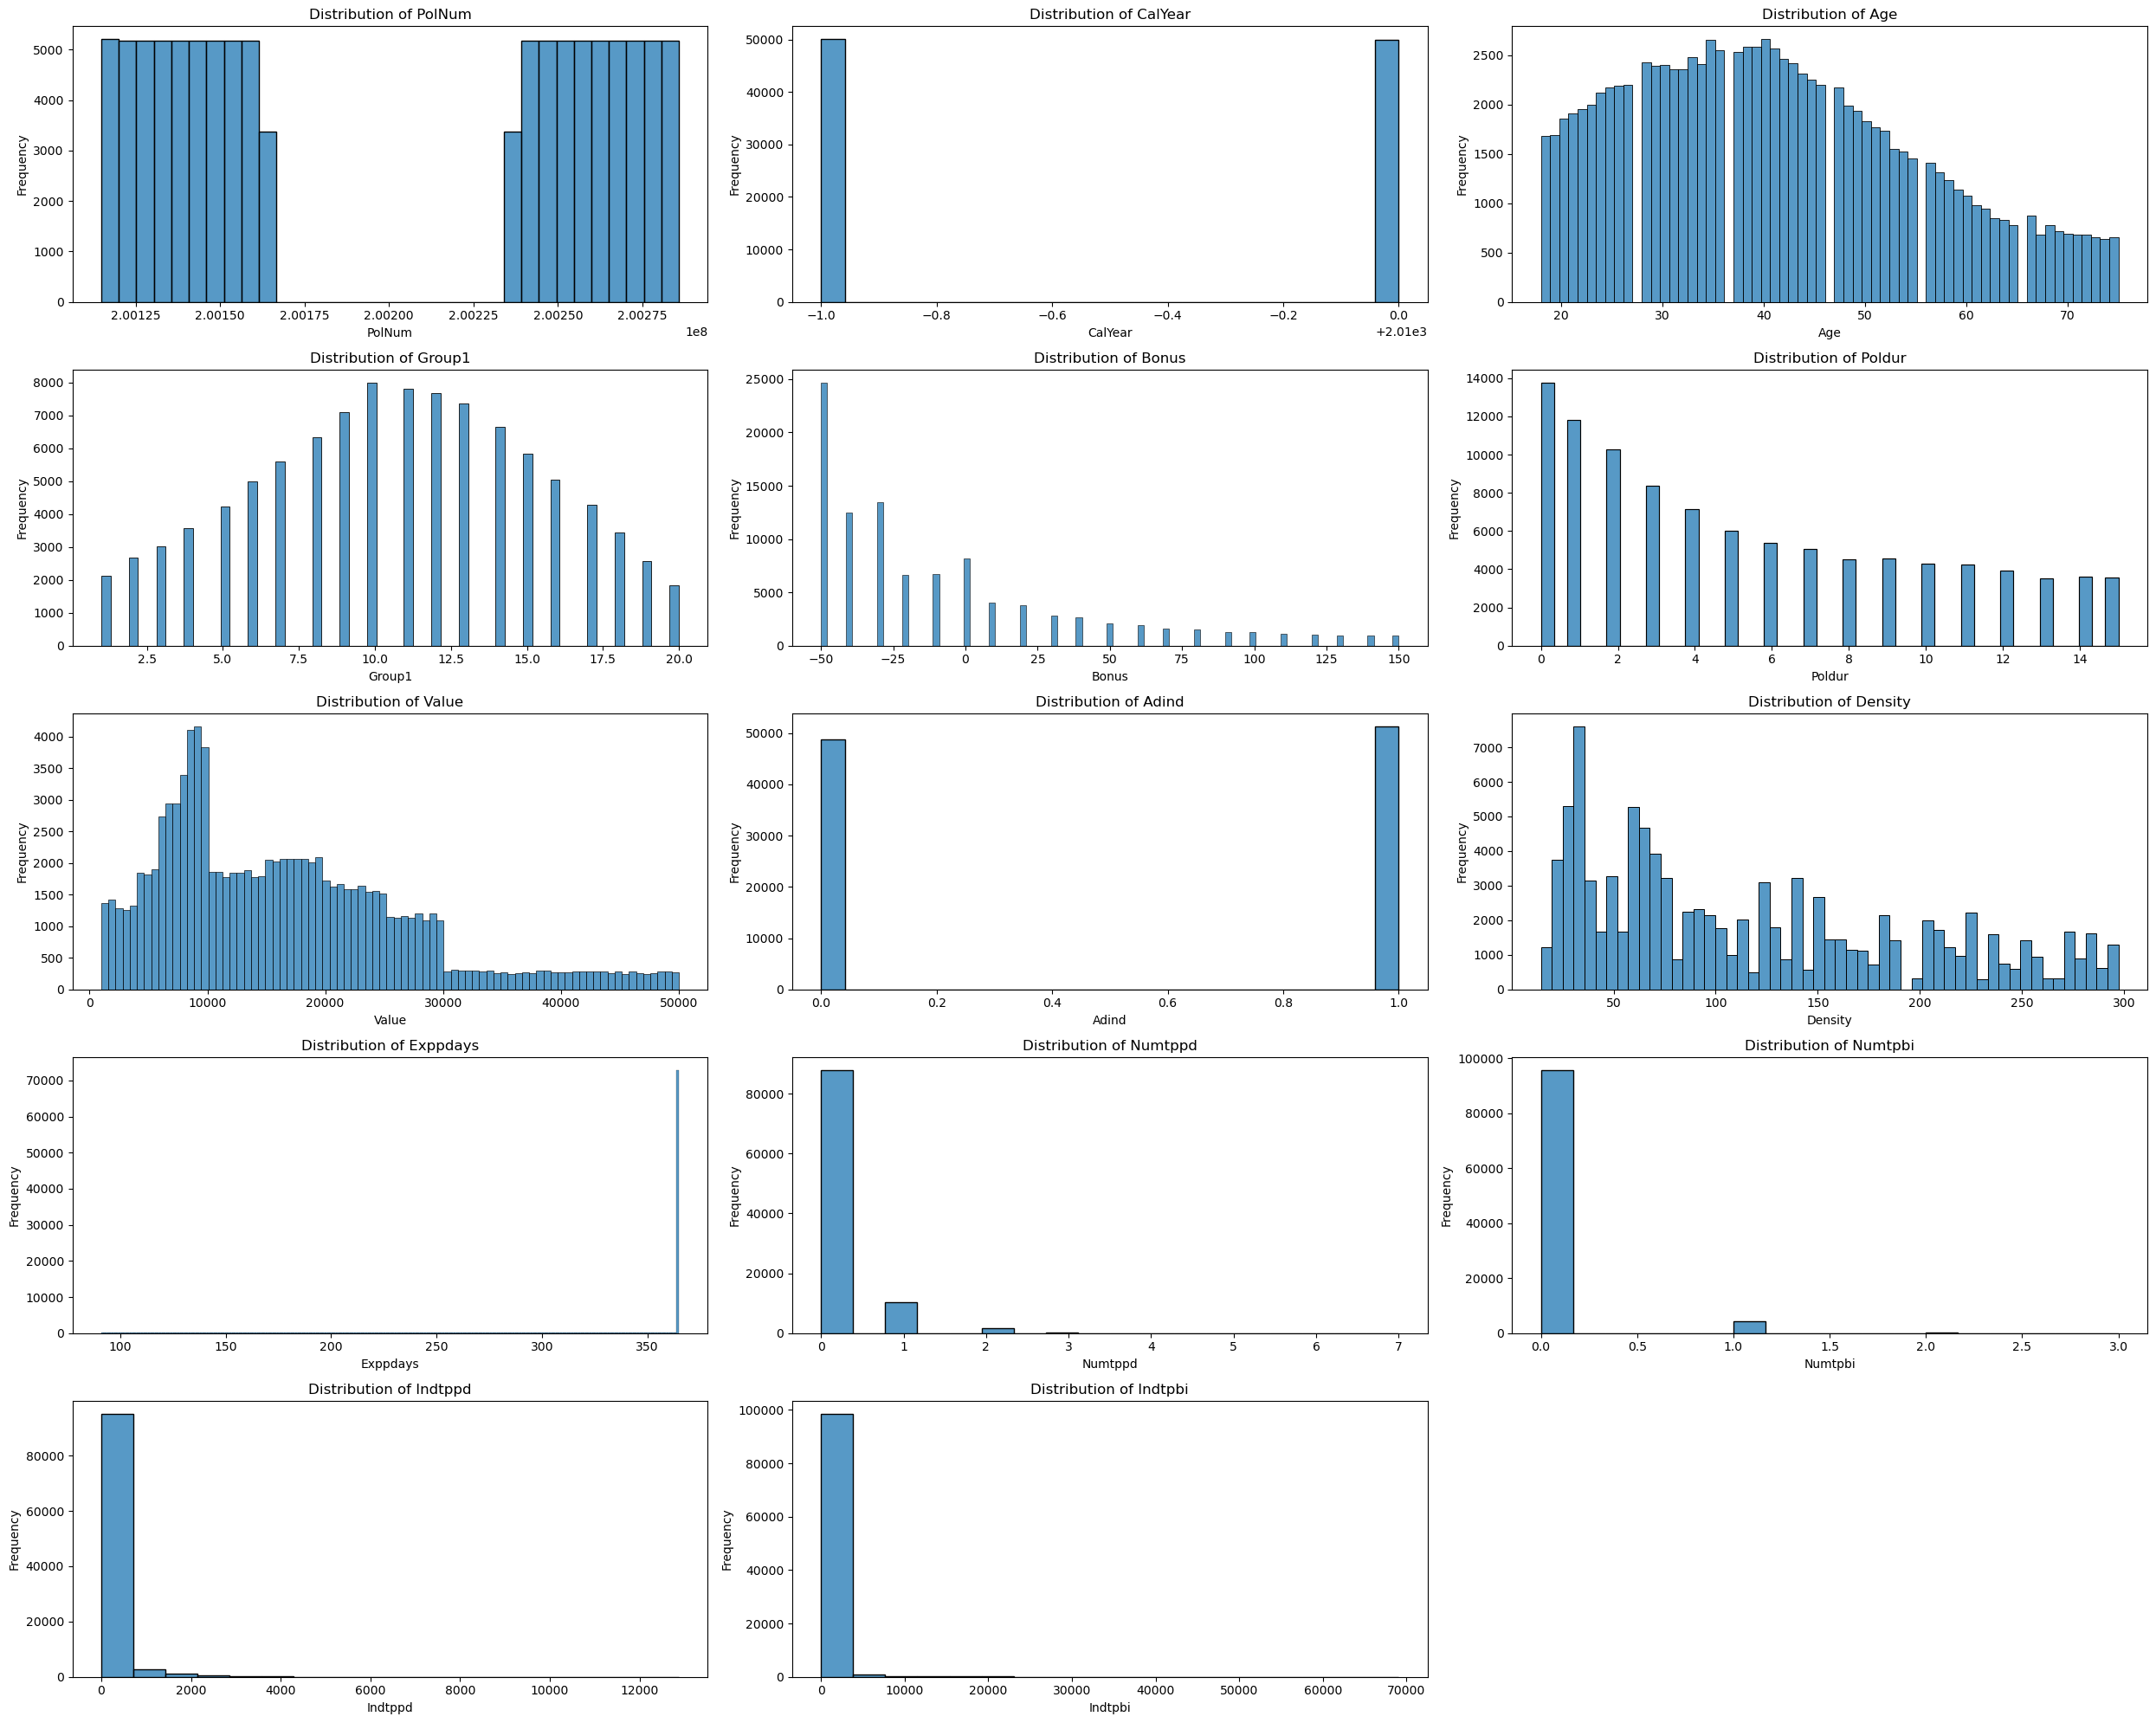

In [18]:
# Univariate analysis for numerical variables
numerical_vars = training_data.select_dtypes(include=[np.number]).columns

# Calculate the number of rows and columns for the layout
num_cols = 3  # Number of columns per row
num_rows = (len(numerical_vars) - 1) // num_cols + 1  # Number of rows

# Distribution plots for numerical variables
plt.figure(figsize=(25, 20))
for i, var in enumerate(numerical_vars):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(training_data[var], kde=False)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

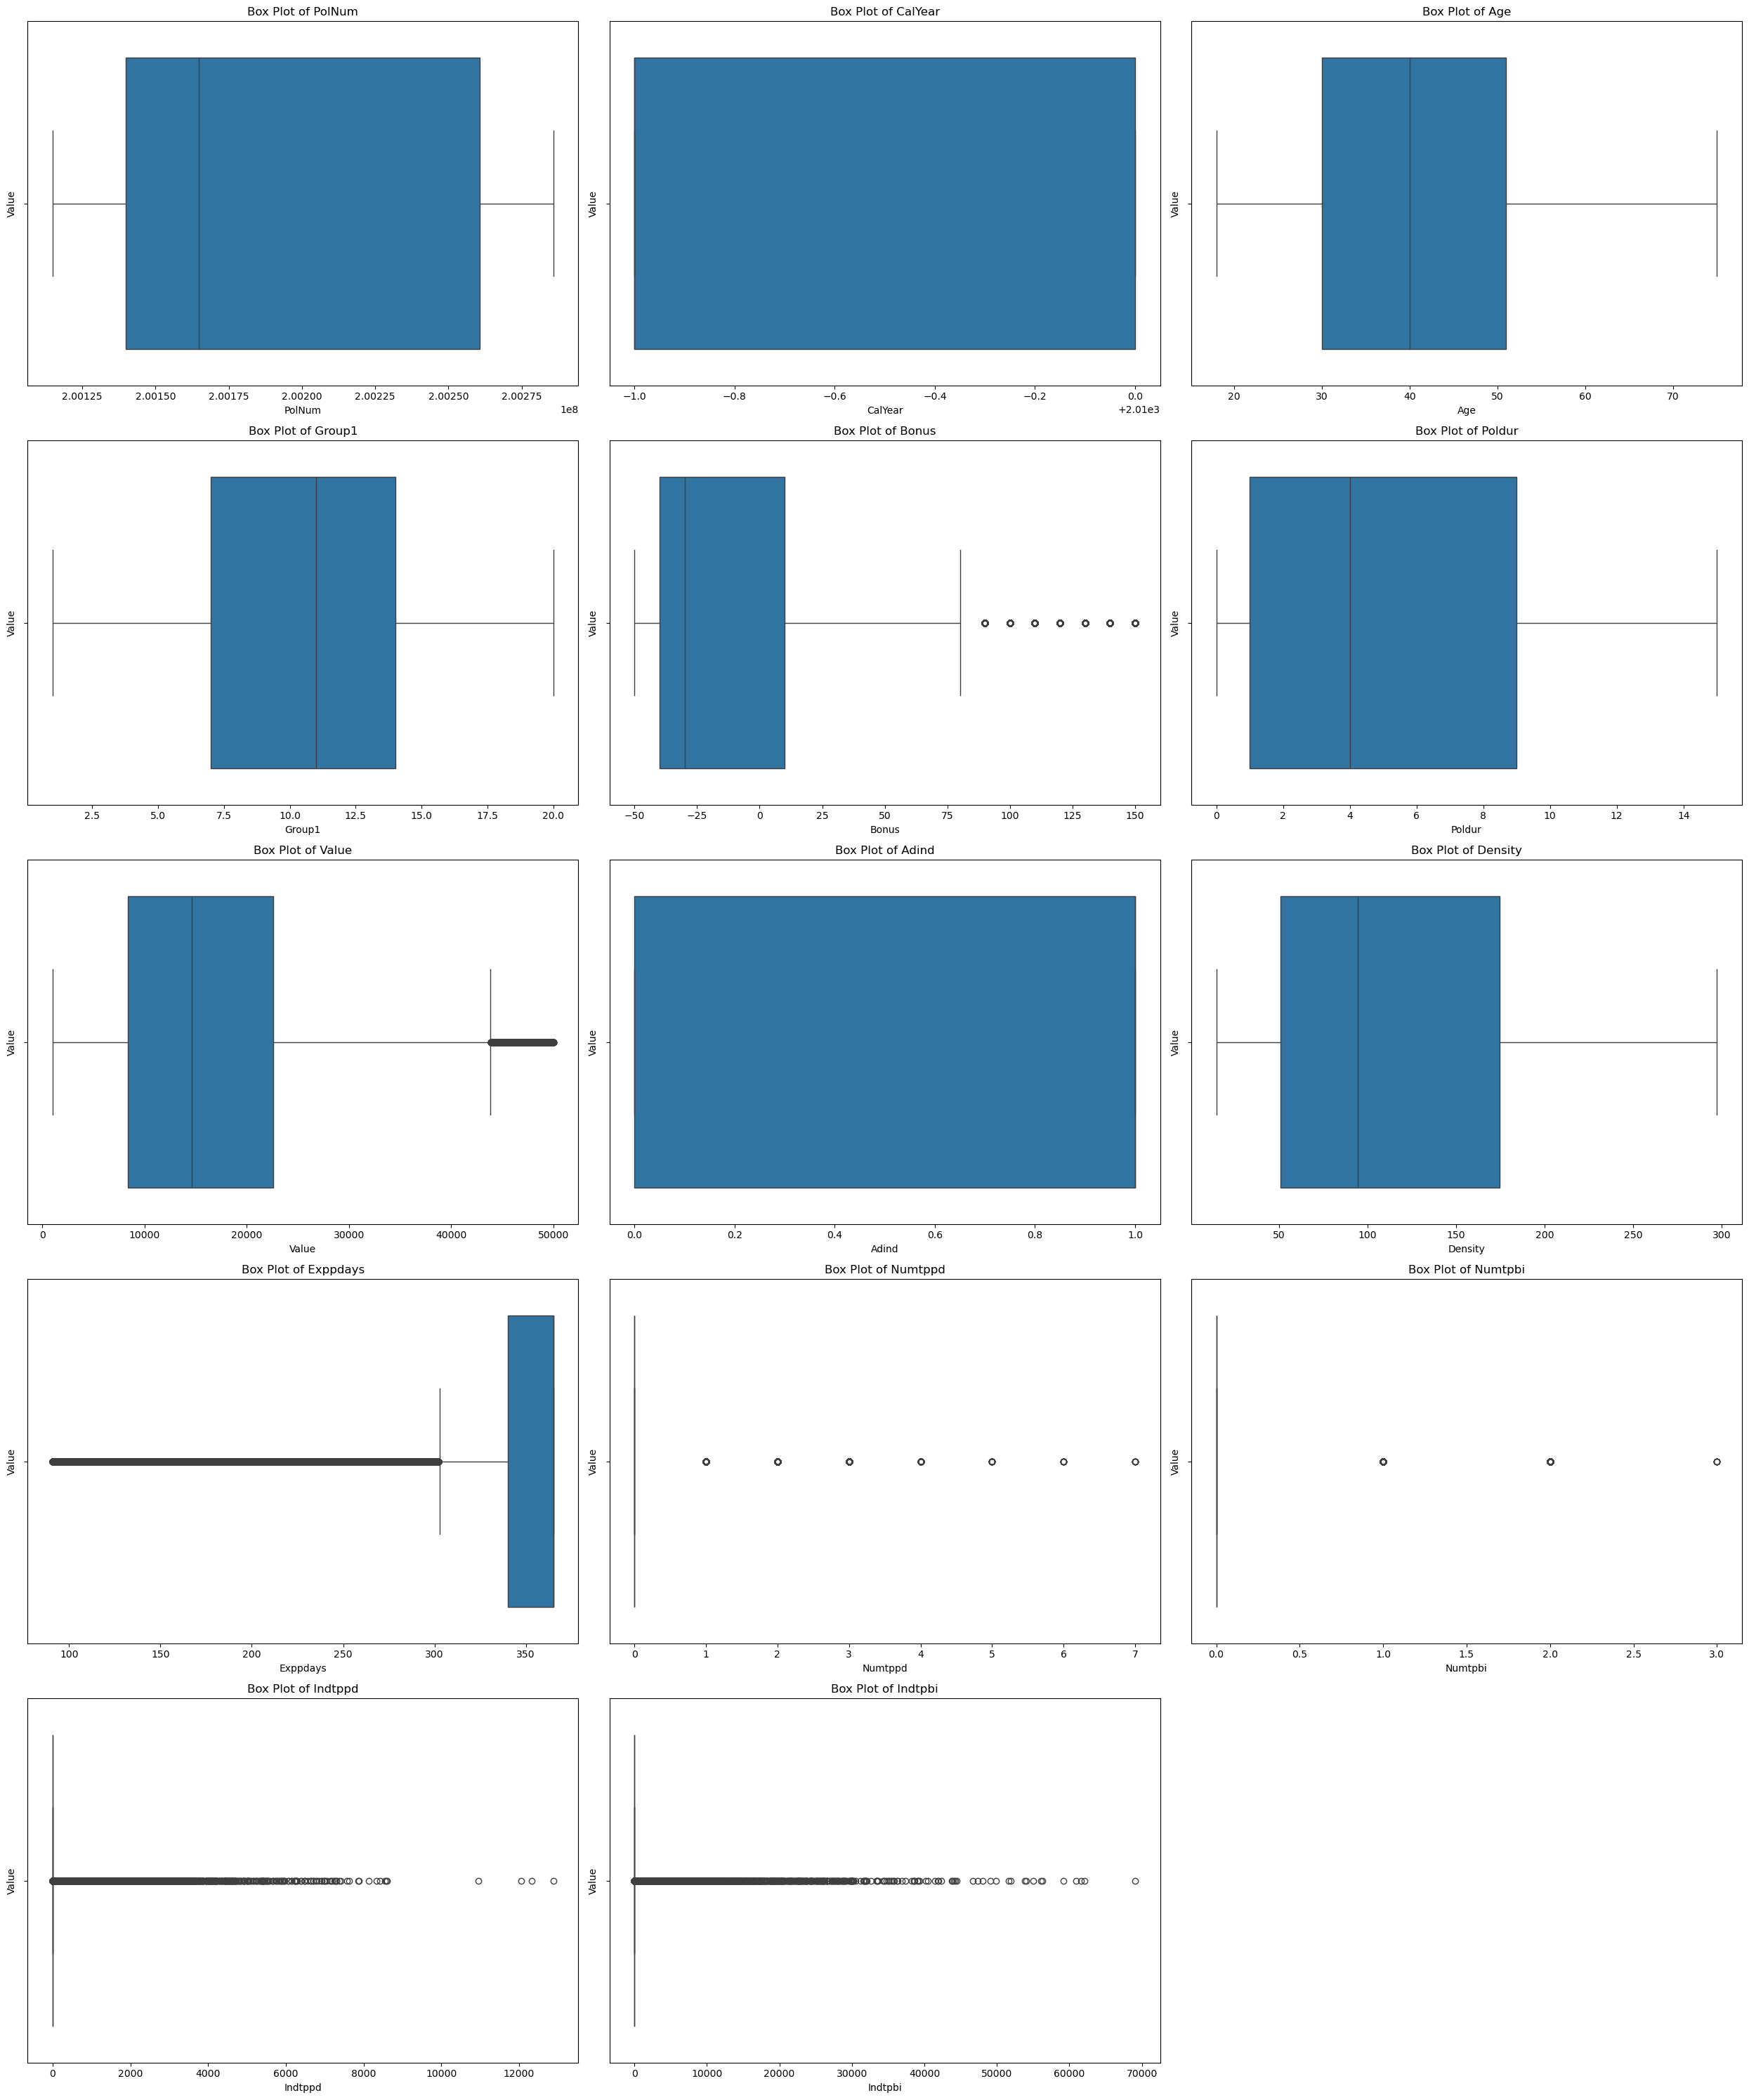

In [19]:
# Univariate analysis for numerical variables
numerical_vars = training_data.select_dtypes(include=[np.number]).columns

# Calculate the number of rows and columns for the layout
num_cols = 3  # Number of columns per row
num_rows = (len(numerical_vars) - 1) // num_cols + 1  # Number of rows

# Box plots for numerical variables
plt.figure(figsize=(25, 30))
for i, var in enumerate(numerical_vars):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(x=var, data=training_data)
    plt.title(f'Box Plot of {var}')
    plt.xlabel(var)
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

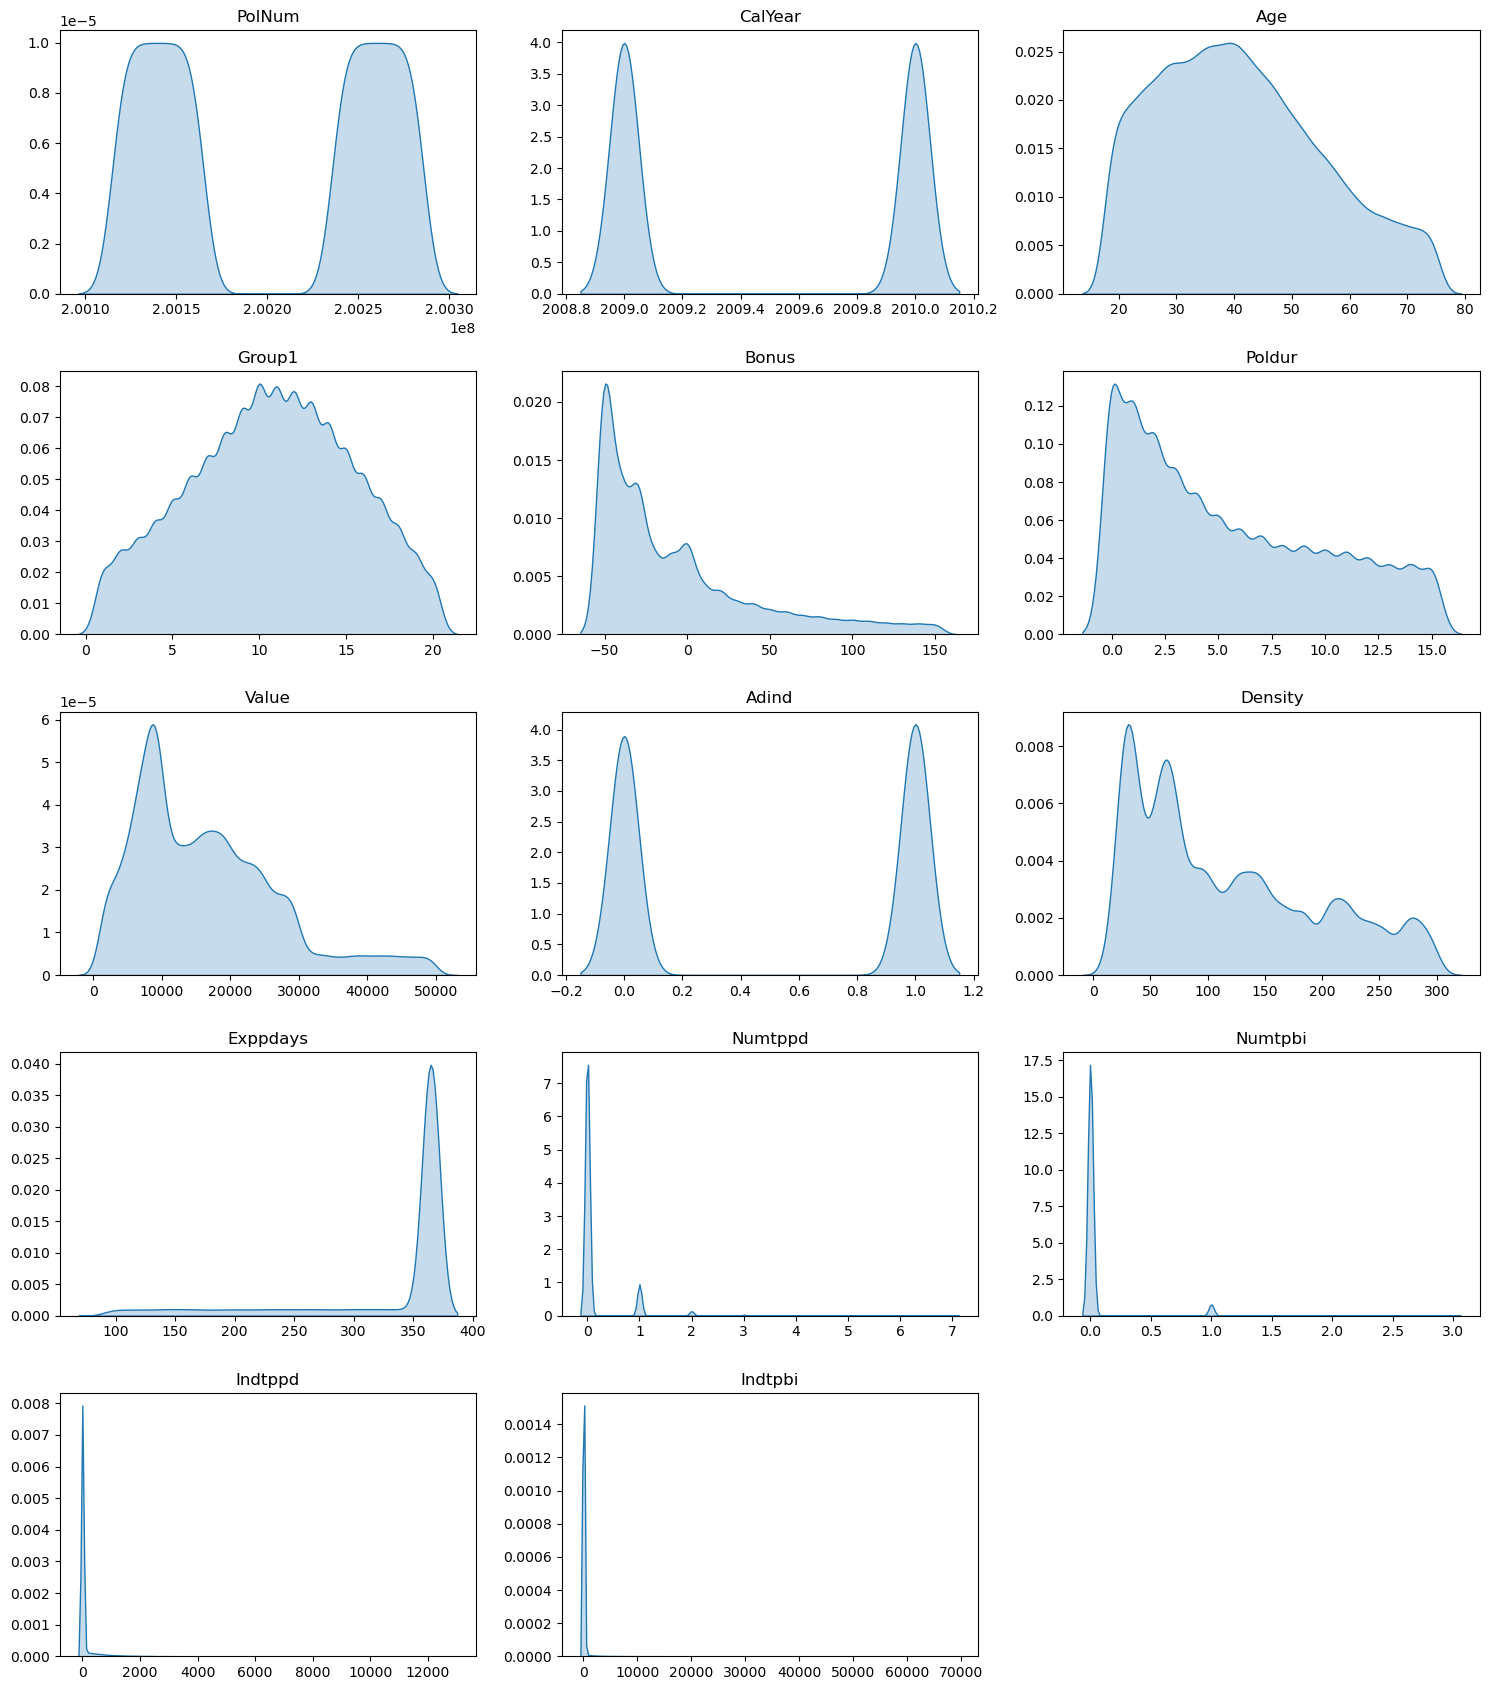

In [20]:
# Determine continuous variables
numerical_vars = training_data.select_dtypes(include=[np.number]).columns.tolist()

# Plot KDE plots for continuous variables
plt.figure(figsize=(15, 17))
for c, var in enumerate(numerical_vars):
    plt.subplot(5, 3, c+1)
    sns.kdeplot(data=training_data, x=var, fill=True)
    plt.title(str(var))
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


Interpretations : 

PolNum: Have a bimodal distribution with two distinct peaks. This could indicate two different groups within the dataset (which are the groups in 2009 and 2010).

CalYear: This distribution is also bimodal, which might suggest two different periods in which data was collect (which are the years 2009 and 2010t.

Age: Shows a distribution that at skewed to tleftght, indicating a younger population, with fewer older individ (between 30 and 50 years old approls.

Group1: The distribution is roughlyngularhaped, possibly indicating a uniform distribution across the range, with a peak a centerthe  (peak corresponds to the group of cars for which we have the highest number of contr.tory)

Bonus: This plot shleft right skew, indicating that bonuses are tyynts) y (discounts) lower with a few larger bonuses bein g lesscommon.

Poldur: lefher right-skewed distribution, implying that shorter policy durations are more commonn than loger ones.

Value: Exhibileftlong right tail, indicating a concentration of lower values with some highaer values s outliers.
Highly skewed to the right, suggesting that most of the expected days are very low with a few extreme values.reme values.

Adind: This variable has a bimodal distribution with two peaks at the extremes and a lower density in the middle, which might suggest two dior behaviors in the data.s in the daShows several peaks and a left skew, which could imply multiple modes of density within the dataset.hthin the dataset.

Numtppd: Another highly skewed distribution with most of the data lowest values (at the beginning)rated at the low end.
 high p: Shows a verwest values at the beginningep peak at the low end, indicating that most values are near zero, with a long tail suggesting outliers.

Indtpd: Shows a concentration of values near zero, with a s Shows a very high peak at the lowest values at the beginning, indicating that most values are near zero, with a long tail suggesting outliers.centration at the low end.low end.ration at the low end.

In [20]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Indtpbi_processed,Indtppd_processed,Bonus_processed
count,1.000210e+05,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000
mean,2.002003e+08,2009.499895,41.122514,10.692625,-6.921646,5.470781,16454.675268,0.512142,117.159270,327.588007,0.147449,0.046790,106.135007,222.762829,53.431082,50.582517,-10.143570
std,6.217239e+04,0.500002,14.299349,4.687286,48.633165,4.591194,10506.742732,0.499855,79.500907,73.564636,0.436917,0.219546,444.949188,1859.422836,409.267436,193.913012,44.038319
min,2.001149e+08,2009.000000,18.000000,1.000000,-50.000000,0.000000,1000.000000,0.000000,14.377142,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.000000
25%,2.001399e+08,2009.000000,30.000000,7.000000,-40.000000,1.000000,8380.000000,0.000000,50.625783,340.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-40.000000
50%,2.001649e+08,2009.000000,40.000000,11.000000,-30.000000,4.000000,14610.000000,1.000000,94.364623,365.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-30.000000
75%,2.002608e+08,2010.000000,51.000000,14.000000,10.000000,9.000000,22575.000000,1.000000,174.644525,365.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
max,2.002858e+08,2010.000000,75.000000,20.000000,150.000000,15.000000,49995.000000,1.000000,297.385170,365.000000,7.000000,3.000000,12878.369910,69068.026292,5796.313276,1440.666933,130.000000


In [21]:
print("Valeurs uniques de la colonne Numtppd:", training_data['Numtppd'].unique())
print("Valeurs uniques de la colonne Numtpbi:", training_data['Numtpbi'].unique())
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus'].unique())

Valeurs uniques de la colonne Numtppd: [1 2 0 3 4 5 6 7]
Valeurs uniques de la colonne Numtpbi: [0 1 2 3]
Valeurs uniques de la colonne Indtppd: [   0.          740.30229036  207.32365675 ...  546.40798246  822.92046036
 5800.0189068 ]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 90  30 150   0  40  80 -20 -40 120 -30  20  50 -50 -10 100  10 110 140
  70  60 130]


In [23]:
# Select only numeric columns
numeric_cols = training_data.select_dtypes(include=['number'])

# Calculate the 90th percentile for each numeric column
percentile_90 = numeric_cols.quantile(0.9)

# Count the number of values above the 90th percentile in each column
count_above_90 = (numeric_cols > percentile_90).sum()

# Calculate the percentage of values above the 90th percentile in each column
percentage_above_90 = (count_above_90 / len(numeric_cols)) * 100

# Display the percentages
print("Percentage of values above the 90th percentile in each column:")
print(percentage_above_90)

Percentage of values above the 90th percentile in each column:
PolNum               9.999900
CalYear              0.000000
Age                  9.530998
Group1               7.824357
Bonus                8.996111
Poldur               7.149499
Value                9.991902
Adind                0.000000
Density              9.701963
Exppdays             0.000000
Numtppd              1.918597
Numtpbi              4.505054
Indtppd              9.999900
Indtpbi              4.505054
Indtpbi_processed    3.283311
Indtppd_processed    9.999900
Bonus_processed      8.764160
dtype: float64


#### Analysis of categorical variables

In [24]:
# Select categorical variables
categorical_var = training_data.select_dtypes(include=["object"]).columns.to_list()
# Number of unique values per variable
training_data[categorical_var].nunique()

Gender          2
Type            6
Category        3
Occupation      5
SubGroup2     471
Group2         10
dtype: int64

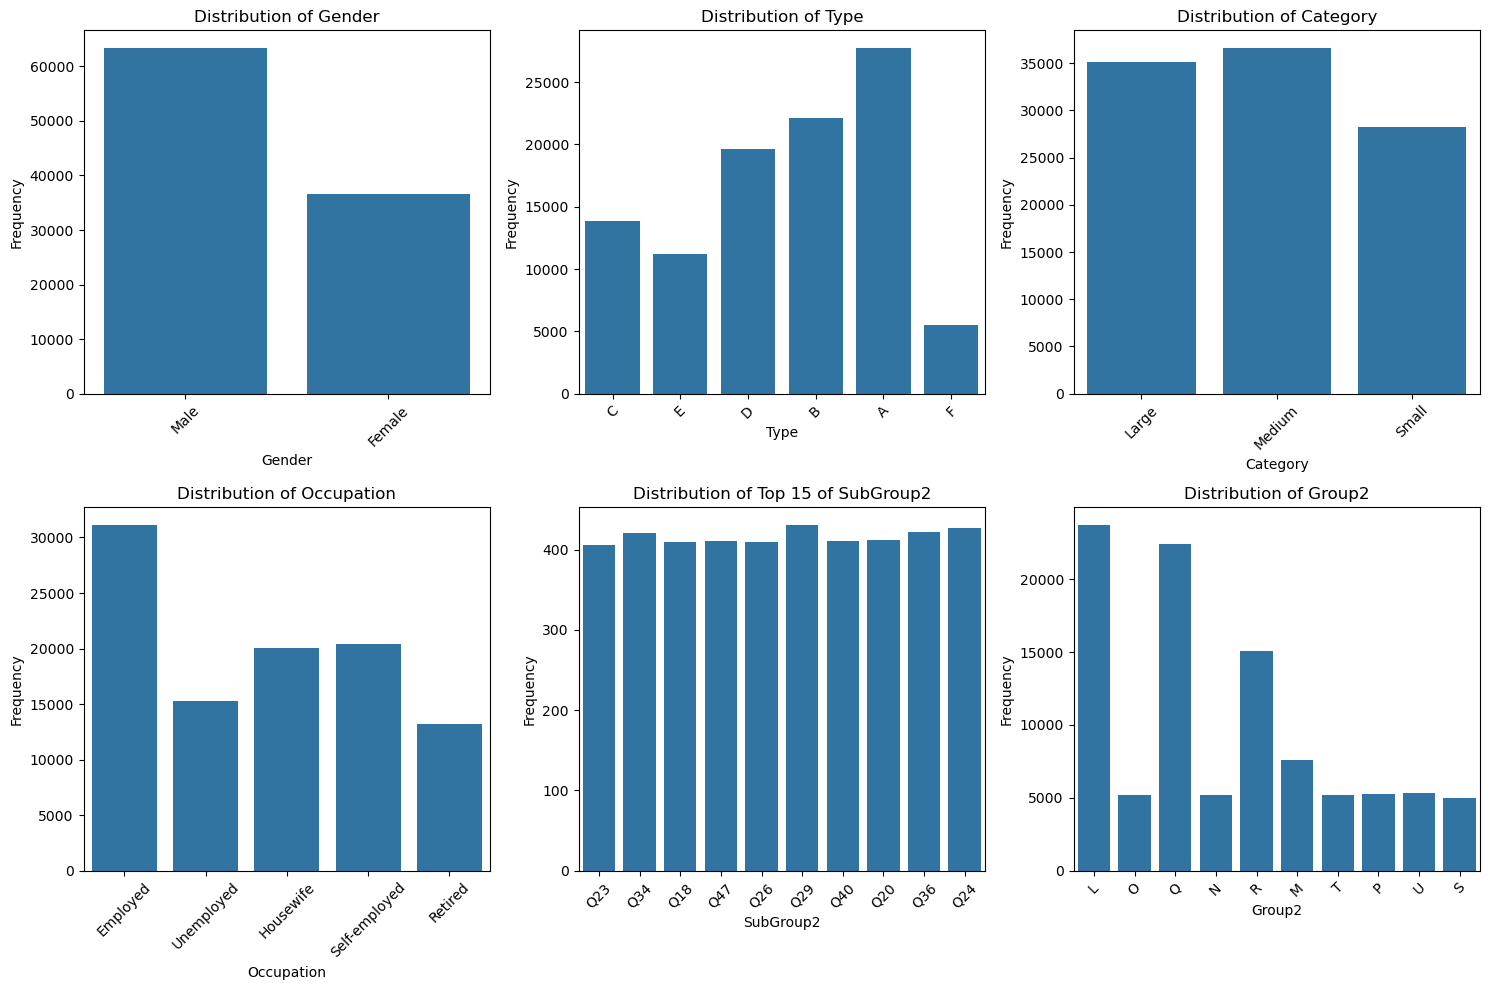

In [28]:
# Univariate analysis for categorical variables
categorical_vars = training_data.select_dtypes(include=['object']).columns

# Calculate the number of rows and columns for the layout
num_cols = 3  # Number of columns per row
num_rows = (len(categorical_vars) - 1) // num_cols + 1  # Number of rows

# Plot categorical variables using count plots
plt.figure(figsize=(15, 10))
for i, var in enumerate(categorical_vars):
    if var == 'SubGroup2':
        top_categories = training_data[var].value_counts().nlargest(10).index
        data_subset = training_data[training_data[var].isin(top_categories)]
        title = f'Distribution of Top 15 of {var}'
    else:
        data_subset = training_data
        title = f'Distribution of {var}'
    plt.subplot(num_rows, num_cols, i+1)
    sns.countplot(x=var, data=data_subset)
    plt.title(title)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

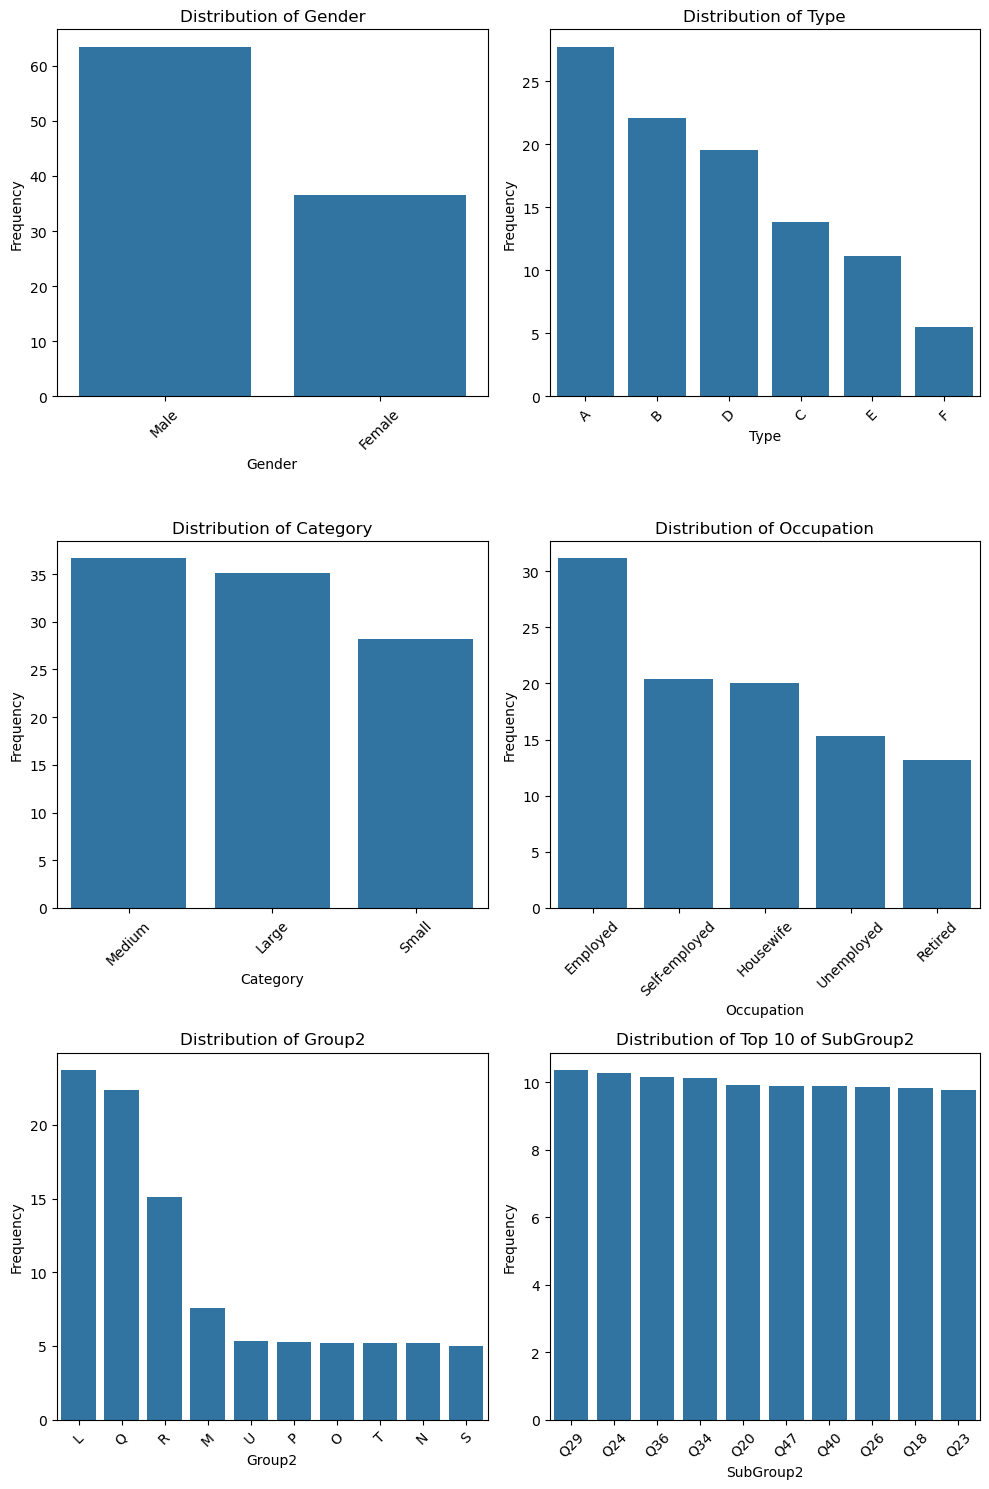

In [29]:
# Select categorical variables with a small number of unique values
df_barplot = training_data[["Gender", "Type", "Category", "Occupation", "Group2", "SubGroup2"]]

# Create barplot with frequency for each variable
plt.figure(figsize=(10, 15))

for c, var in enumerate(df_barplot.columns):
    if var == 'SubGroup2':
        top_categories = training_data[var].value_counts().nlargest(10).index
        data_subset = training_data[training_data[var].isin(top_categories)]
        title = f'Distribution of Top 10 of {var}'
    else:
        data_subset = training_data
        title = f'Distribution of {var}'

    # Compute frequency of each unique value
    df = data_subset[var].value_counts(normalize=True).to_frame("frequency").reset_index()
    df["frequency"] *= 100

    # Plot the barplot
    plt.subplot(3, 2, c+1)
    sns.barplot(data=df, x=var, y="frequency")
    plt.title(title)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [30]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100021 entries, 1 to 100021
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   PolNum             100021 non-null  int64  
 1   CalYear            100021 non-null  int64  
 2   Gender             100021 non-null  object 
 3   Type               100021 non-null  object 
 4   Category           100021 non-null  object 
 5   Occupation         100021 non-null  object 
 6   Age                100021 non-null  int64  
 7   Group1             100021 non-null  int64  
 8   Bonus              100021 non-null  int64  
 9   Poldur             100021 non-null  int64  
 10  Value              100021 non-null  int64  
 11  Adind              100021 non-null  int64  
 12  SubGroup2          100021 non-null  object 
 13  Group2             100021 non-null  object 
 14  Density            100021 non-null  float64
 15  Exppdays           100021 non-null  int64  
 16  Numtppd

In [31]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.isnull().sum()

PolNum               0
CalYear              0
Gender               0
Type                 0
Category             0
Occupation           0
Age                  0
Group1               0
Bonus                0
Poldur               0
Value                0
Adind                0
SubGroup2            0
Group2               0
Density              0
Exppdays             0
Numtppd              0
Numtpbi              0
Indtppd              0
Indtpbi              0
Indtpbi_processed    0
Indtppd_processed    0
Bonus_processed      0
dtype: int64

##### **2. Multivariate Data Analysis**

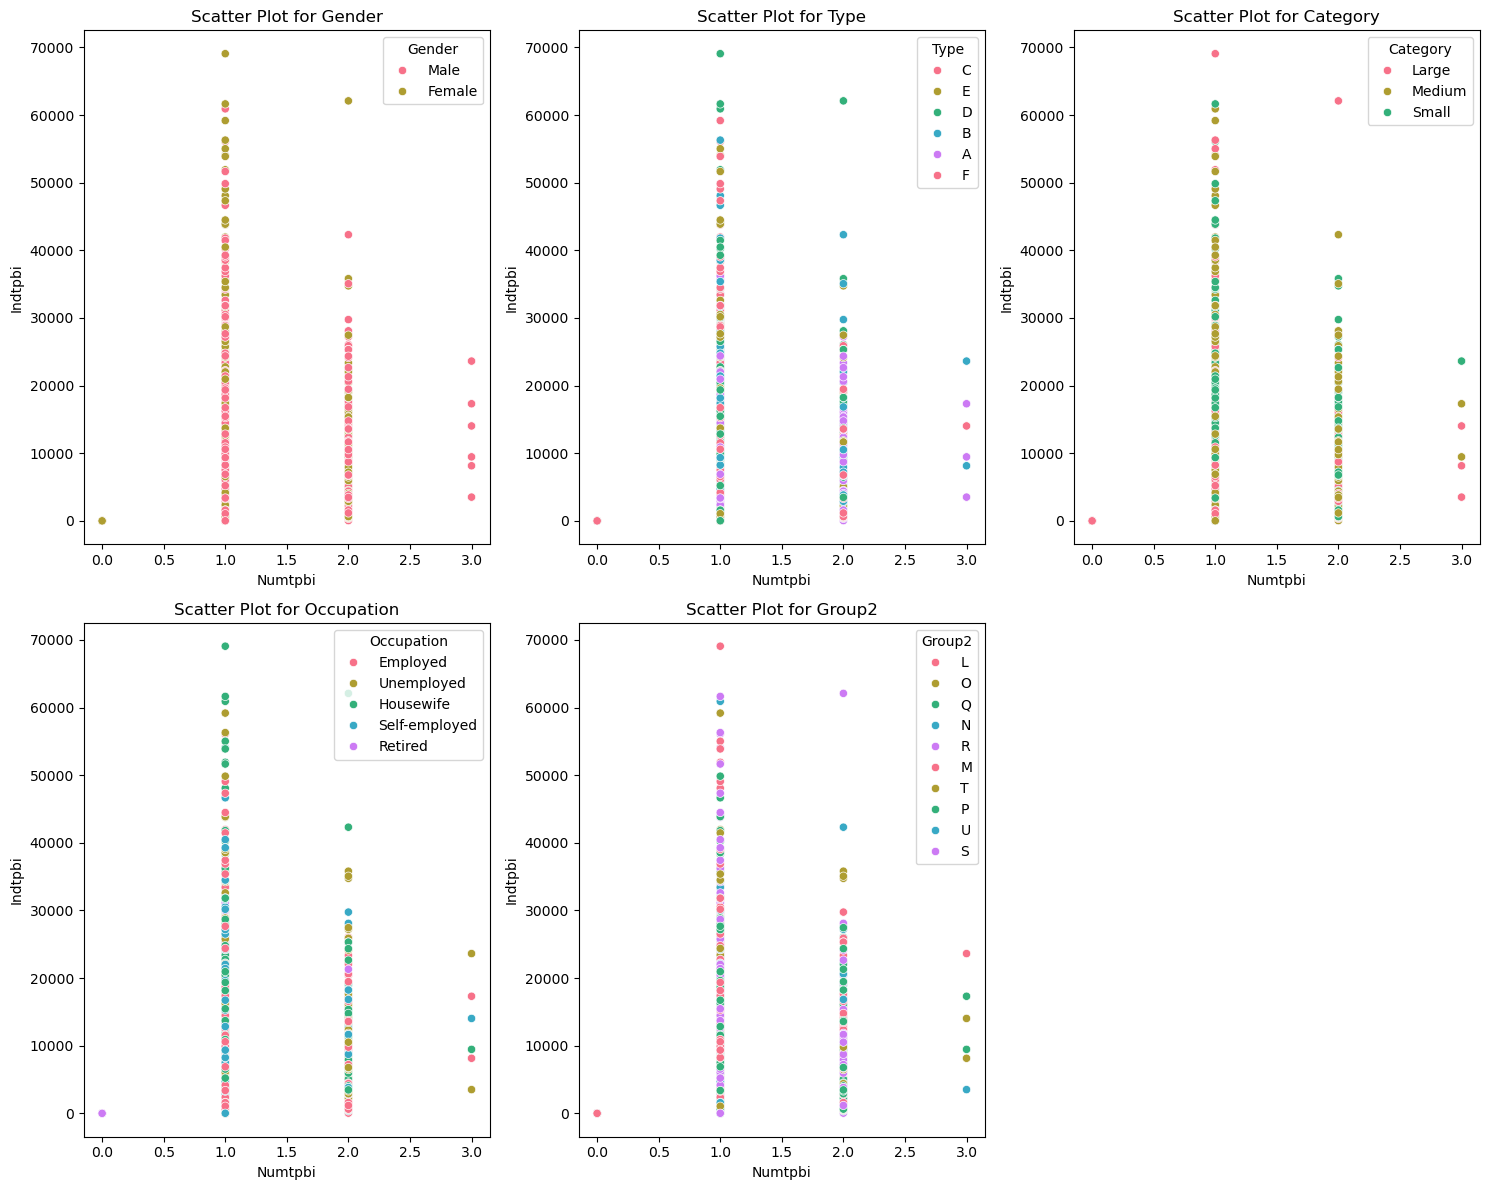

In [32]:
# Select the categorical variables from your dataset
categorical_vars = ["Gender", "Type", "Category", "Occupation", "Group2"]

# Set the color palette for the categorical variables
palette = sns.color_palette("husl", len(categorical_vars))

# Calculate the number of rows and columns for subplots
num_plots = len(categorical_vars)
num_rows = (num_plots + 2) // 3  # Calculate number of rows, rounding up
num_cols = min(num_plots, 3)  # Maximum 3 columns

# Create the figure and axes for the plots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 6*num_rows))

# Flatten the axes if necessary
if num_plots > 1:
    axes = axes.flatten()

# Plot the scatter plots for each categorical variable
for i, var in enumerate(categorical_vars):
    row = i // num_cols
    col = i % num_cols
    sns.scatterplot(x='Numtpbi', y='Indtpbi', ax=axes[i], data=training_data, hue=var, palette=palette)
    axes[i].set_title(f'Scatter Plot for {var}')

# Hide any extra subplots
for j in range(num_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


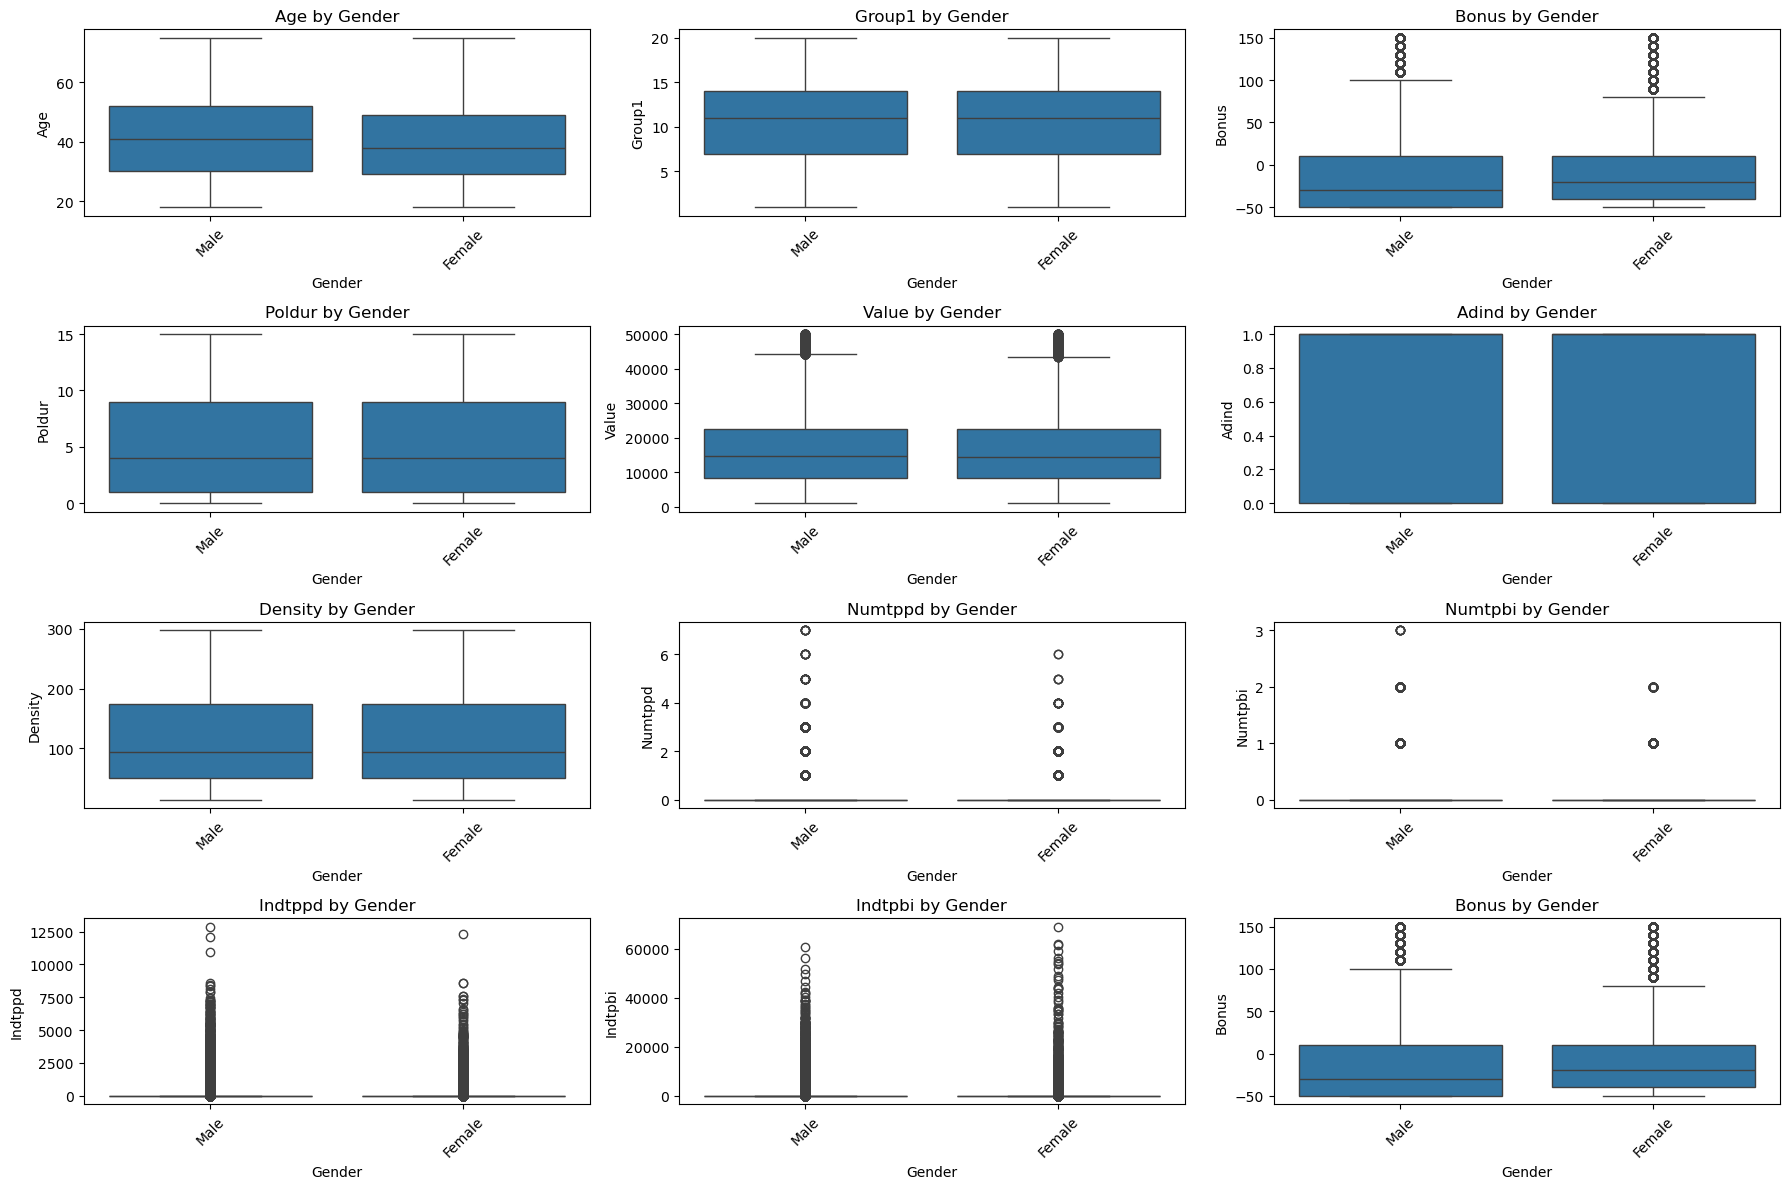

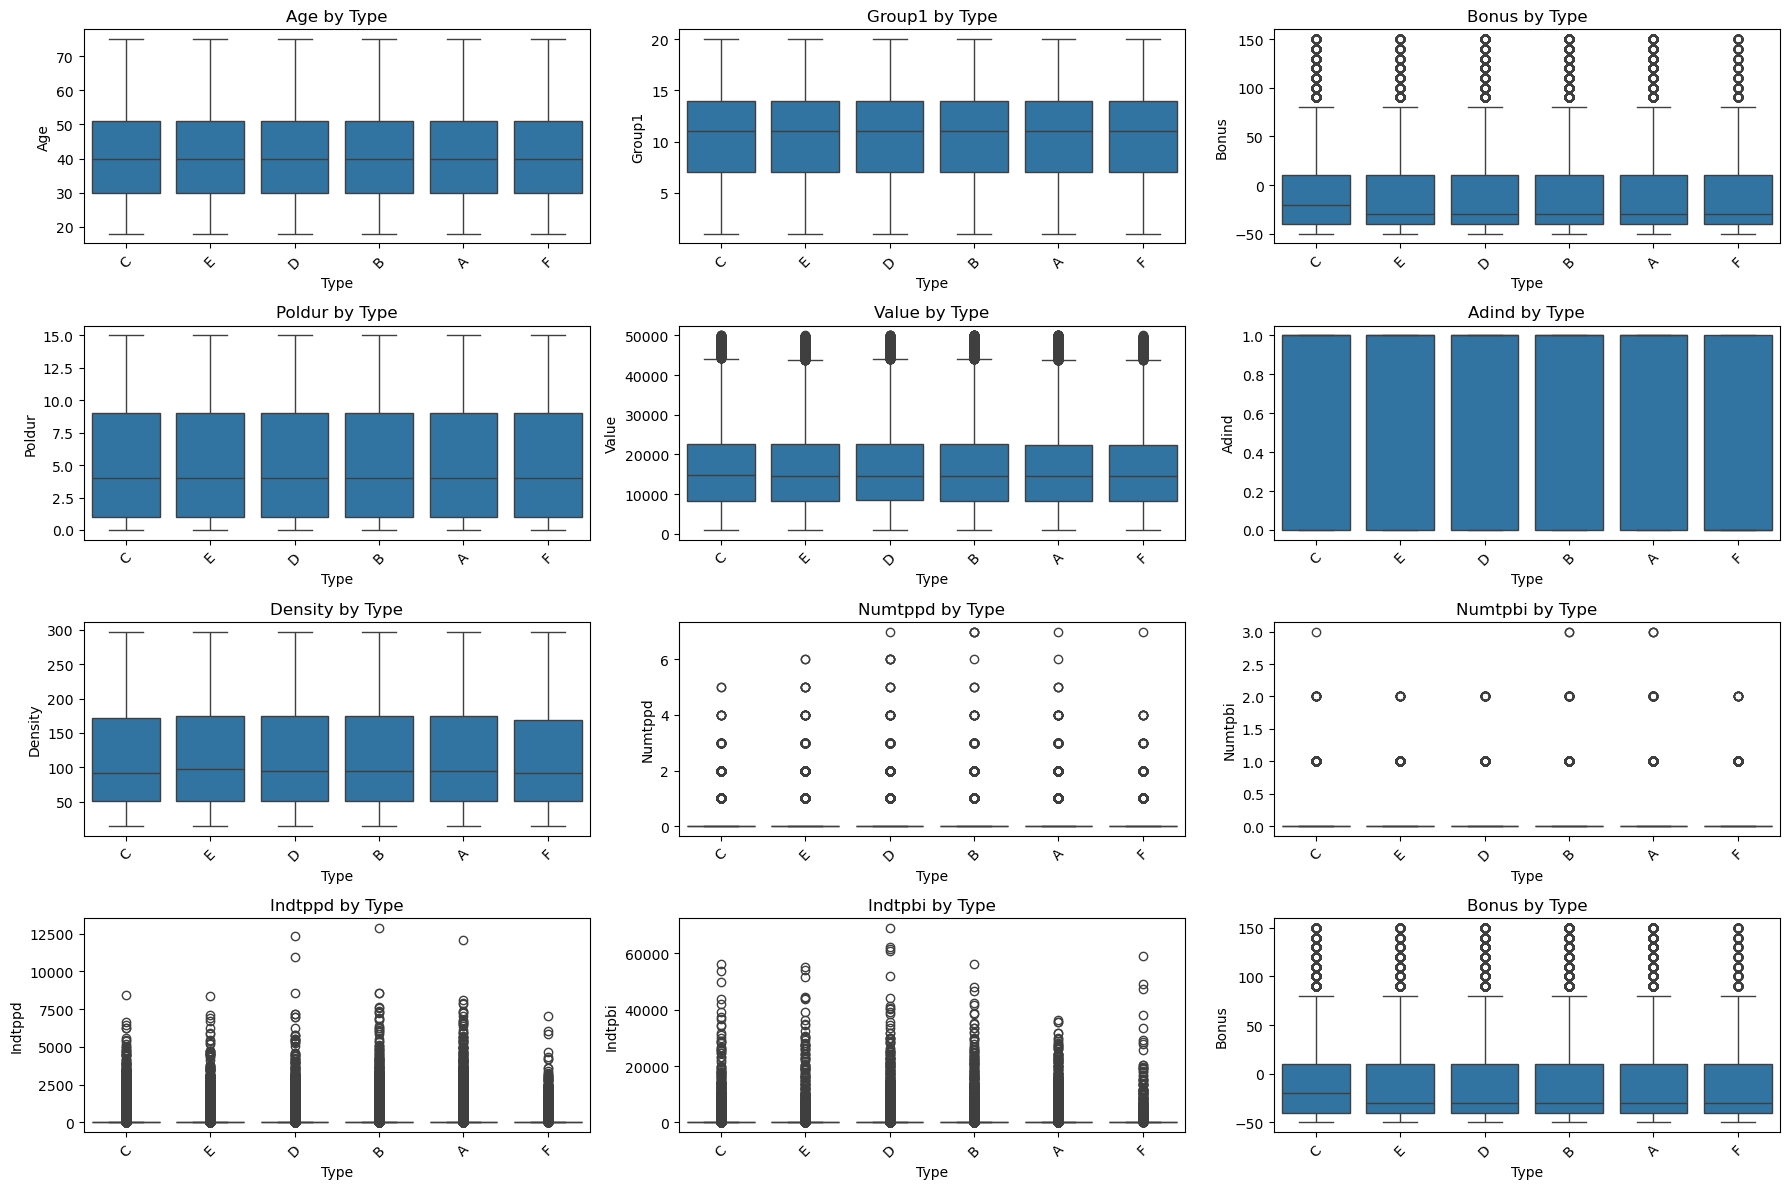

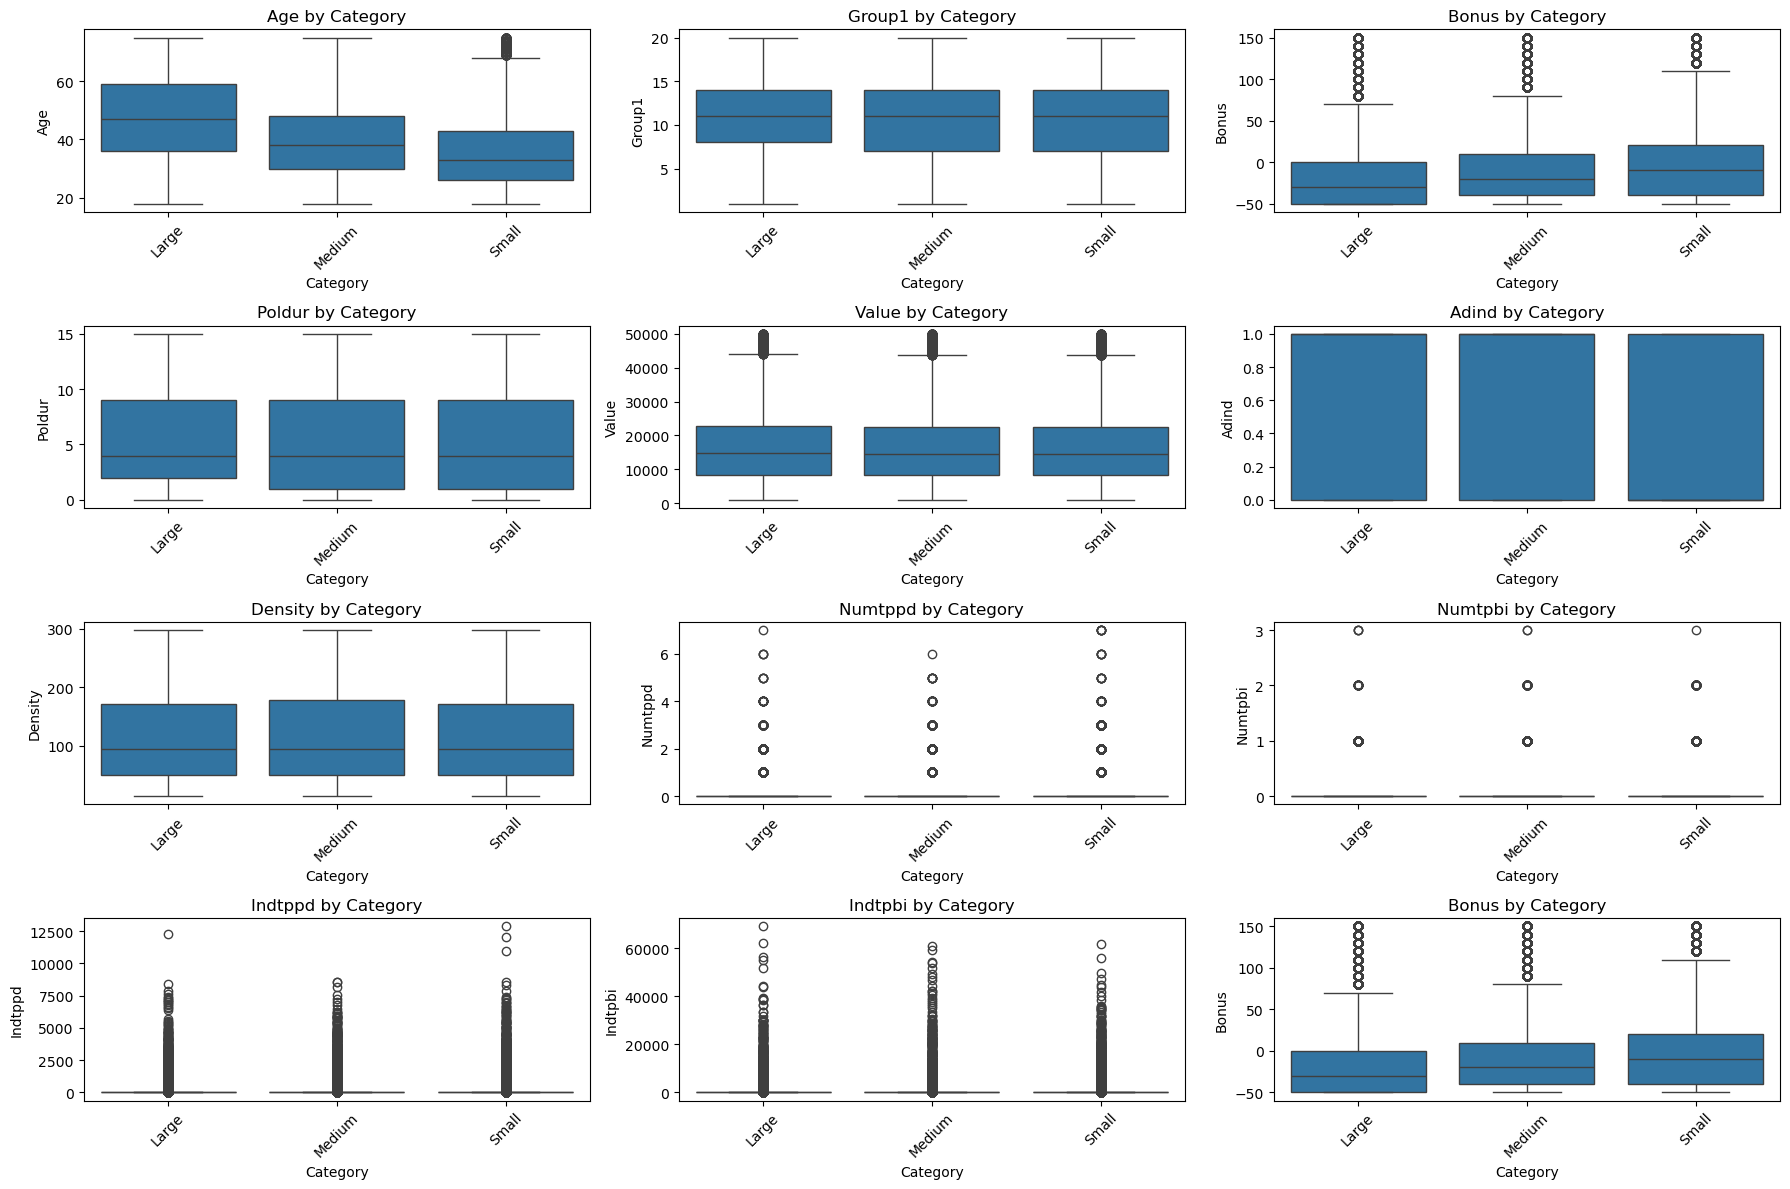

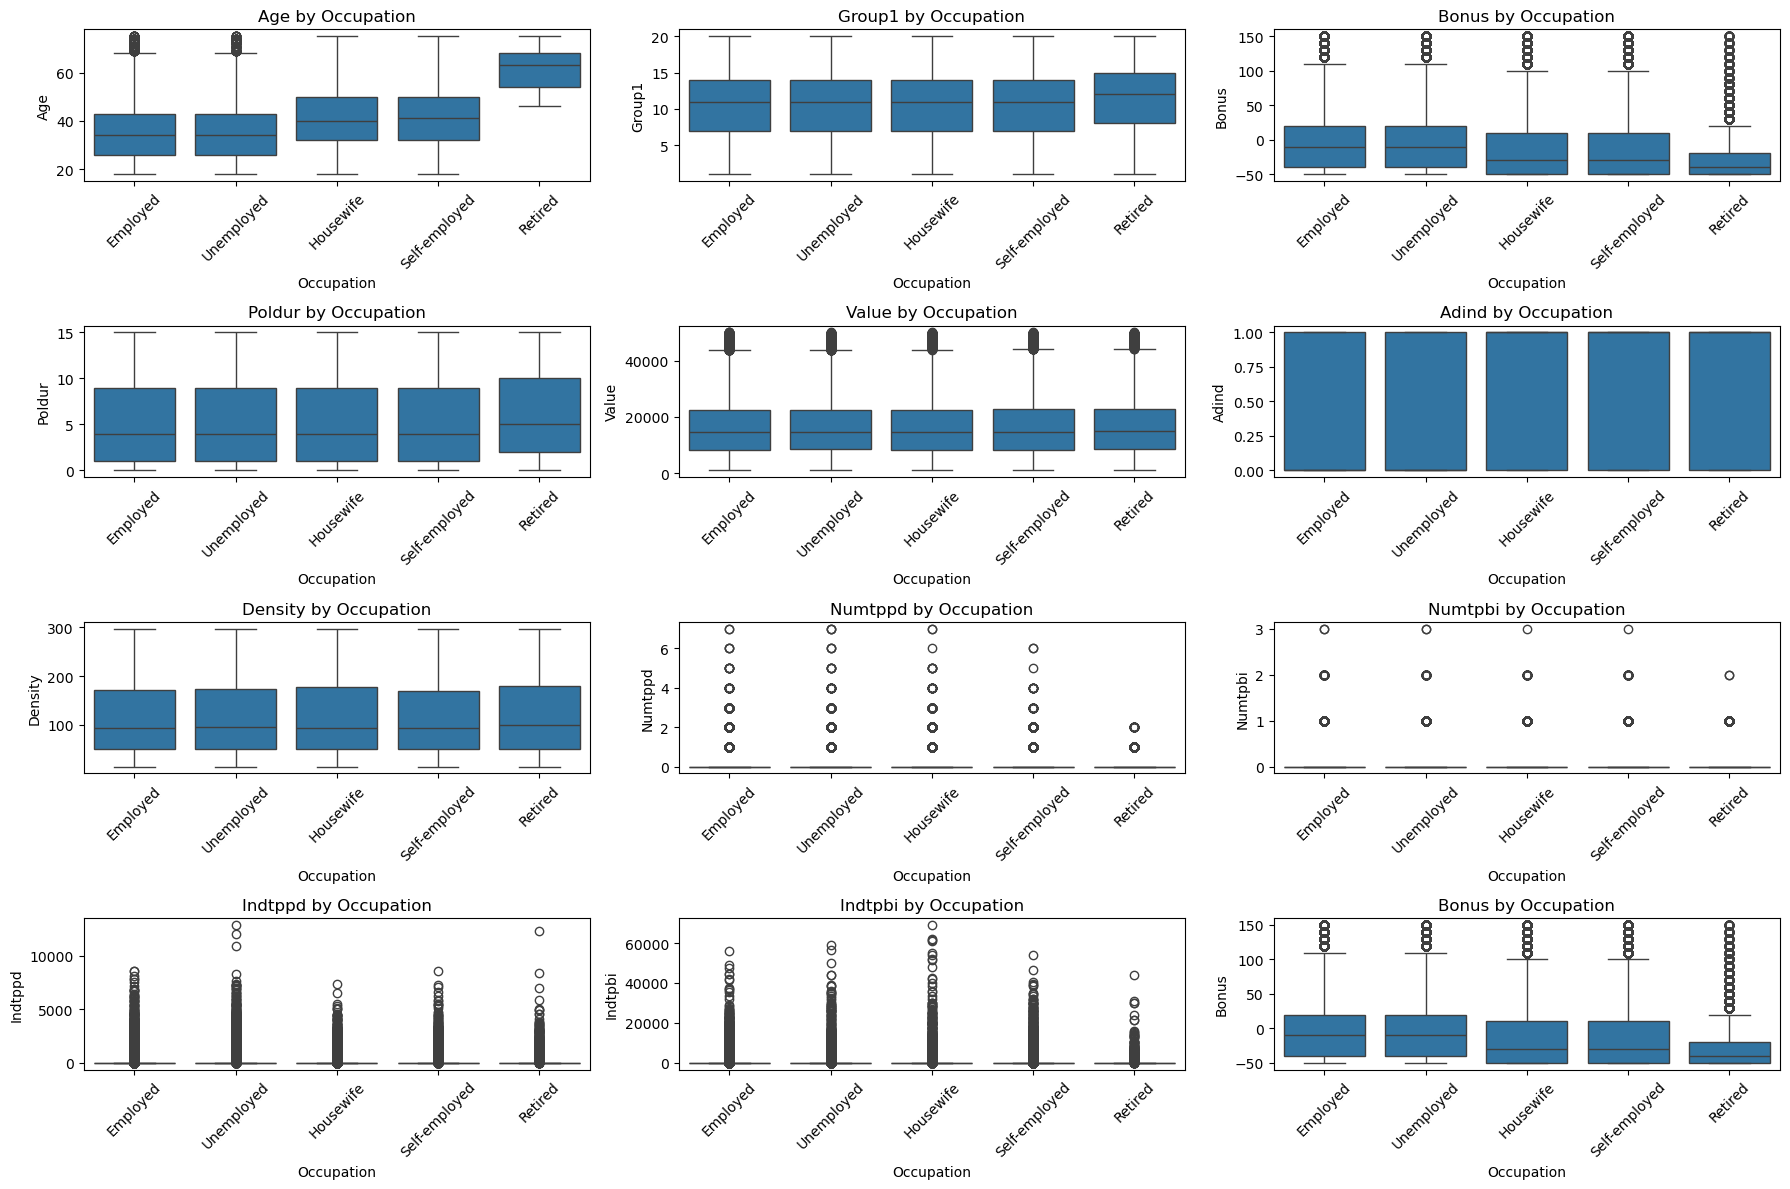

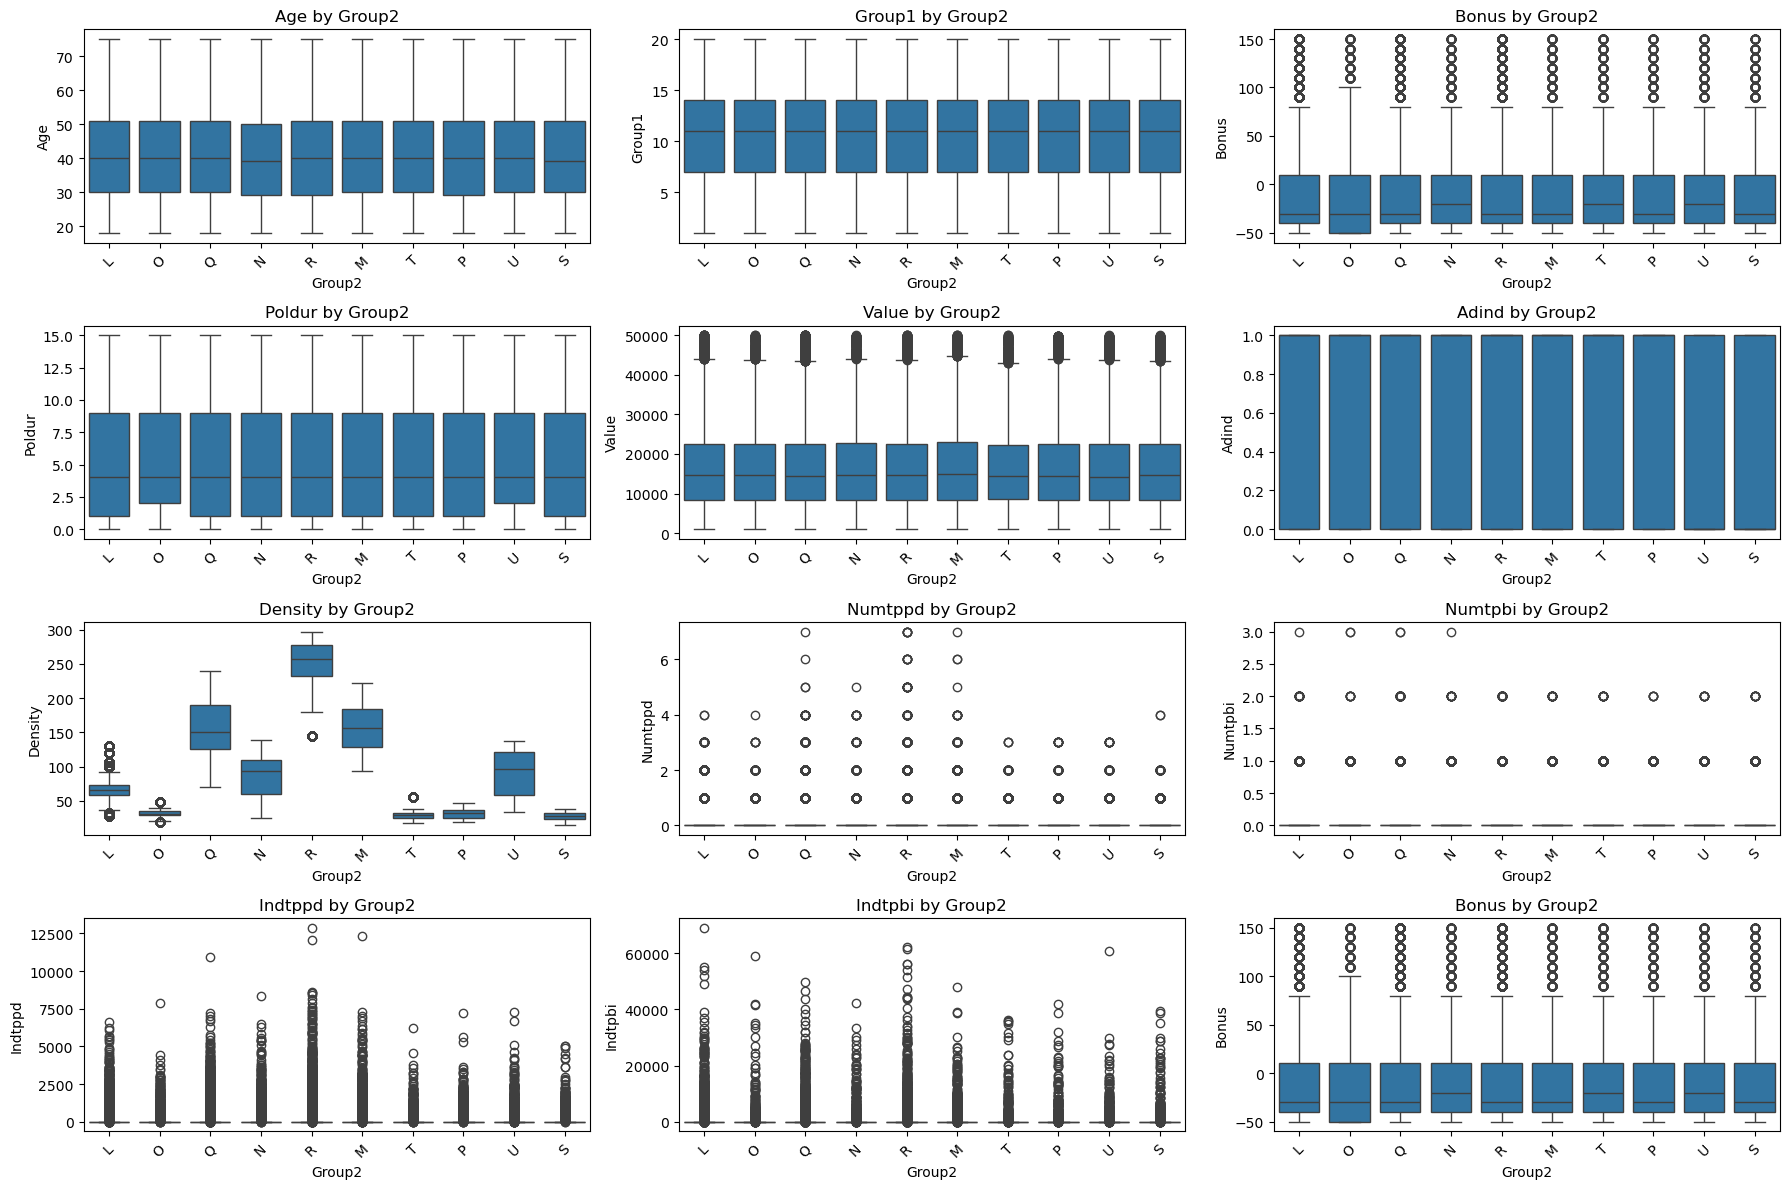

In [33]:
#Categorical and Continuous
# Select continuous variables
continuous_vars = ['Age', 'Group1', 'Bonus', 'Poldur', 'Value', 'Adind', 'Density', 'Numtppd', 'Numtpbi',
                   'Indtppd', 'Indtpbi', 'Bonus']

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']

# Calculate the number of rows and columns needed for the layout
num_cols = 3  
num_rows = (len(continuous_vars) - 1) // num_cols + 1  

# Visualize the relationship between each continuous variable and each categorical variable
for cat_var in categorical_vars:
    plt.figure(figsize=(18, 12))
    for i, cont_var in enumerate(continuous_vars, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(x=cat_var, y=cont_var, data=training_data)
        plt.title(f'{cont_var} by {cat_var}')
        plt.xlabel(cat_var)
        plt.ylabel(cont_var)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


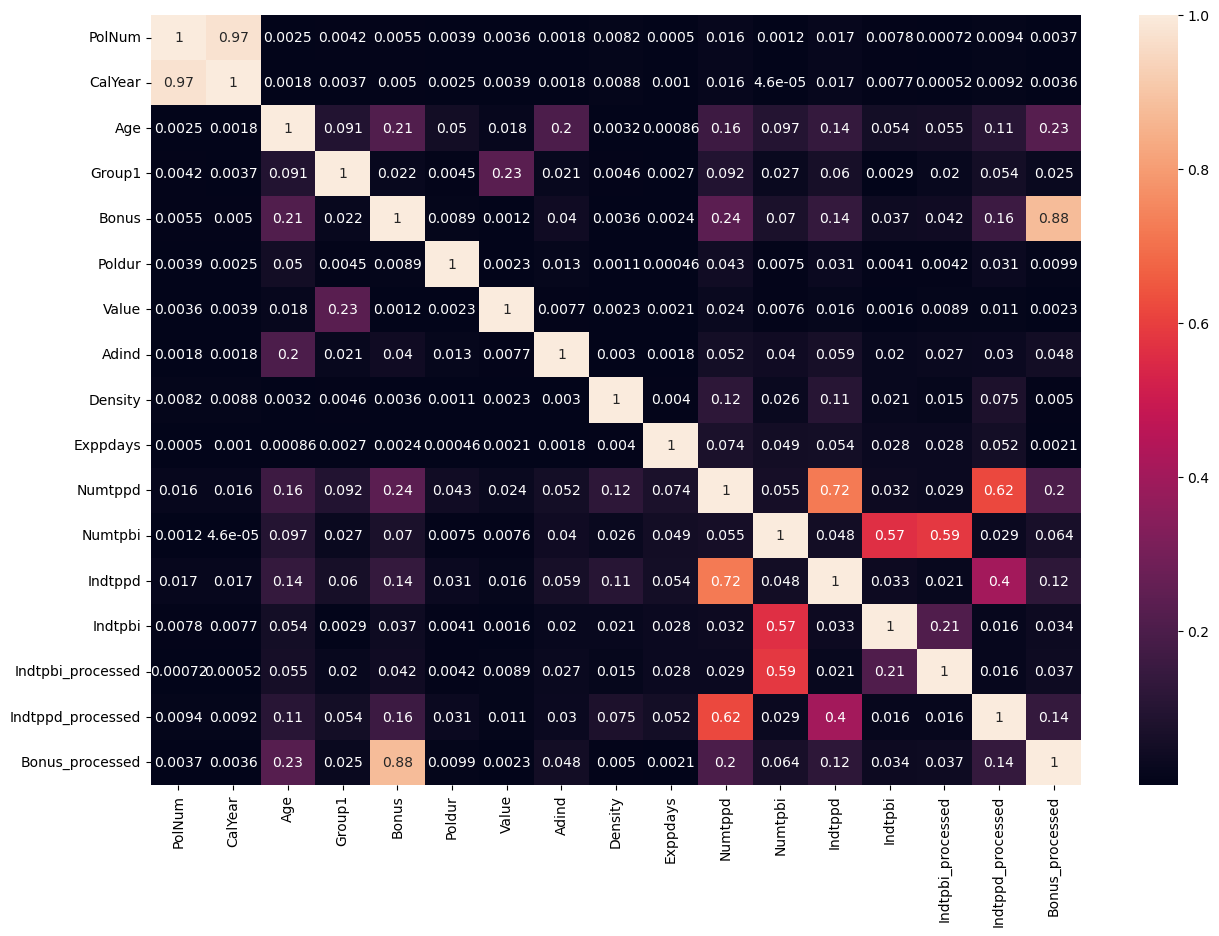

In [34]:
#Continuous and continuous 
numeric_cols = training_data.select_dtypes(include=['number'])  # Select only numeric columns
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_cols.corr().abs(), annot=True)
plt.show()

In [35]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Indtpbi_processed,Indtppd_processed,Bonus_processed
PolNum,1.000000,0.972667,0.002485,0.004175,-0.005531,-0.003895,-0.003639,0.001764,0.008203,-0.000497,0.016106,0.001217,0.016711,0.007758,0.000716,0.009395,-0.003689
CalYear,0.972667,1.000000,0.001821,0.003681,-0.005003,-0.002544,-0.003861,0.001795,0.008755,-0.001047,0.016180,-0.000046,0.017064,0.007688,-0.000522,0.009171,-0.003624
Age,0.002485,0.001821,1.000000,0.090973,-0.214690,0.050484,0.017842,0.203033,0.003174,0.000863,-0.162853,-0.097282,-0.137889,-0.054483,-0.055362,-0.106214,-0.226543
Group1,0.004175,0.003681,0.090973,1.000000,-0.022209,0.004490,0.231667,0.020505,0.004588,0.002743,0.091533,0.026548,0.059937,0.002907,0.020016,0.054272,-0.024901
Bonus,-0.005531,-0.005003,-0.214690,-0.022209,1.000000,-0.008891,-0.001229,-0.040354,-0.003643,-0.002402,0.236655,0.070457,0.140030,0.037060,0.041991,0.157627,0.875649
Poldur,-0.003895,-0.002544,0.050484,0.004490,-0.008891,1.000000,0.002306,0.012535,-0.001056,0.000464,-0.043223,-0.007521,-0.031090,-0.004129,-0.004224,-0.030808,-0.009921
Value,-0.003639,-0.003861,0.017842,0.231667,-0.001229,0.002306,1.000000,0.007748,0.002325,-0.002056,0.023859,0.007637,0.015581,0.001563,0.008888,0.011363,-0.002279
Adind,0.001764,0.001795,0.203033,0.020505,-0.040354,0.012535,0.007748,1.000000,0.003019,0.001841,-0.052238,-0.039524,-0.059245,-0.020352,-0.027254,-0.030462,-0.047602
Density,0.008203,0.008755,0.003174,0.004588,-0.003643,-0.001056,0.002325,0.003019,1.000000,-0.003989,0.121018,0.026220,0.105476,0.021282,0.014783,0.075368,-0.005018
Exppdays,-0.000497,-0.001047,0.000863,0.002743,-0.002402,0.000464,-0.002056,0.001841,-0.003989,1.000000,0.074080,0.048895,0.054129,0.027526,0.028113,0.051894,-0.002074


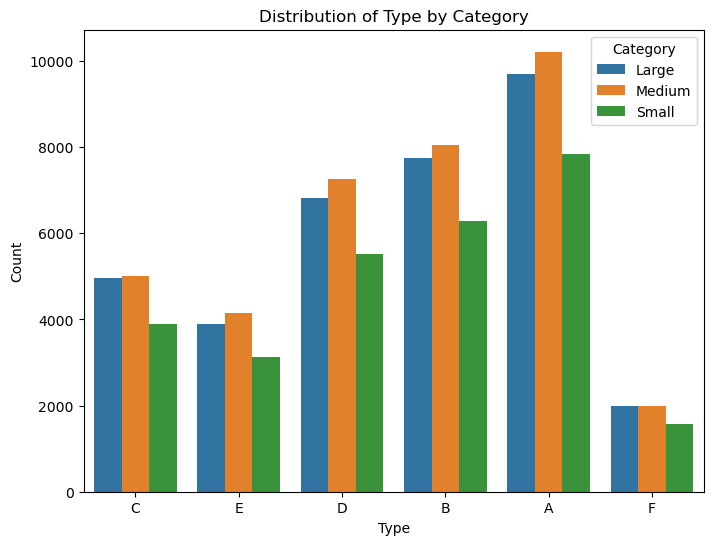

In [36]:
#categorical VS categorical 
plt.figure(figsize=(8, 6))
sns.countplot(x='Type', hue='Category', data=training_data)
plt.title('Distribution of Type by Category')
plt.xlabel('Type')
plt.ylabel('Count')
plt.legend(title='Category')
plt.show()

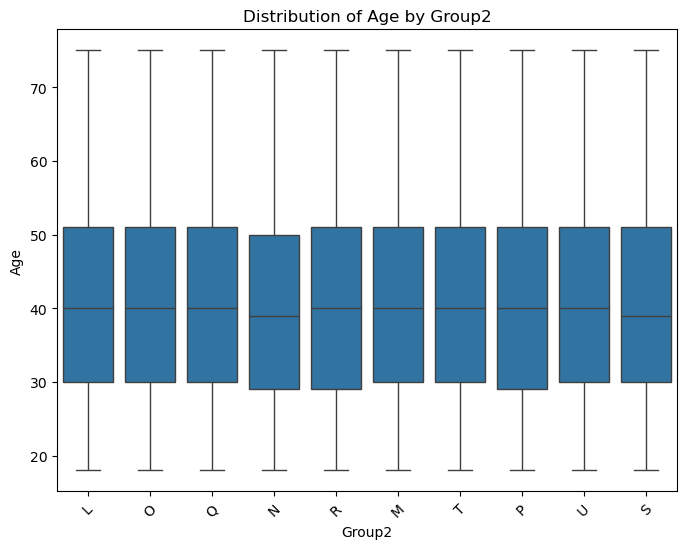

In [37]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group2', y='Age', data=training_data)
plt.title('Distribution of Age by Group2')
plt.xlabel('Group2') #groupe 2 represents the drivers'home region
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

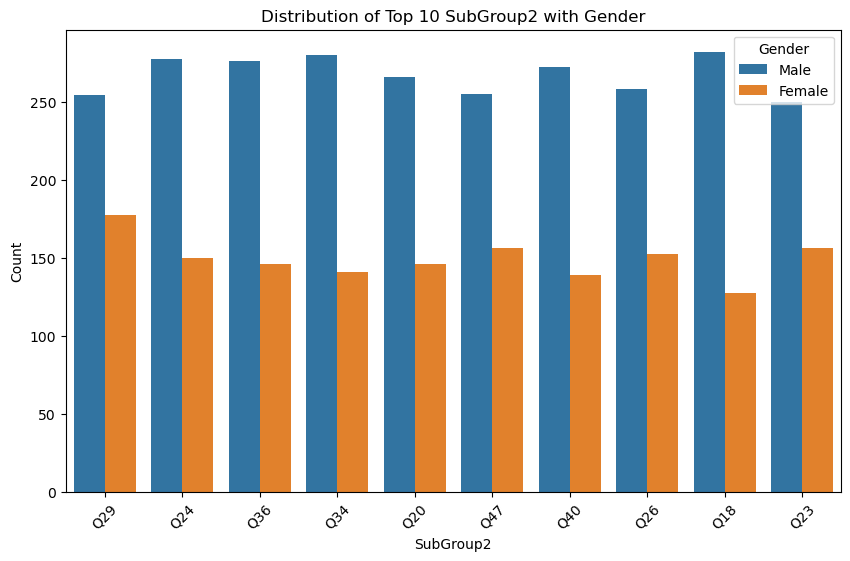

In [38]:
# Get the top 10 categories in 'SubGroup2'
top_subgroup2 = training_data['SubGroup2'].value_counts().nlargest(10).index #recall : SubGroup2: Driver's home sub-region.

# Filter the dataset for the top 10 categories
top_subgroup2_data = training_data[training_data['SubGroup2'].isin(top_subgroup2)] 

# Create the count plot with hue as 'Gender'
plt.figure(figsize=(10, 6))
sns.countplot(x='SubGroup2', hue='Gender', data=top_subgroup2_data, order=top_subgroup2)
plt.title('Distribution of Top 10 SubGroup2 with Gender')
plt.xlabel('SubGroup2')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.show()


The p-value resulting from the Chi-squared test indicates the statistical significance of the relationship between the target variable and each categorical variable.
And the Cramer's V is as well a statistical measure used to assess the association between categorical variables. Cramer's V ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. It  provides a standardized measure of the strength of association, allowing for easier interpretation and comparison across different studies or datasets.
NB : Group 2 have a strong relationship and at the same time have a high p value which means that the variables can be independent ! 

In [40]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Indtpbi'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Indtpbi: p-value = 0.8934007138622158
Cramer's V for Gender and Indtpbi: 0.20941124866173572
Chi-squared test result for Type and Indtpbi: p-value = 0.44802267811822194
Cramer's V for Type and Indtpbi: 0.47478773727715157
Chi-squared test result for Category and Indtpbi: p-value = 0.04073179482604187
Cramer's V for Category and Indtpbi: 0.30399445159088456
Chi-squared test result for Occupation and Indtpbi: p-value = 0.9999999011104369
Cramer's V for Occupation and Indtpbi: 0.4128243203114816
Chi-squared test result for Group2 and Indtpbi: p-value = 0.9951087065940399
Cramer's V for Group2 and Indtpbi: 0.6308394778142368


In [161]:
#  Creating new target variable
training_data['Prime_pbi'] = training_data['Numtpbi'] * training_data['Indtpbi_processed']

In [162]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Indtpbi_processed,Indtppd_processed,Bonus_processed,Prime_pbi
PolNum,1.000000,0.972667,0.002485,0.004175,-0.005531,-0.003895,-0.003639,0.001764,0.008203,-0.000497,0.016106,0.001217,0.016711,0.007758,0.000716,0.009395,-0.003689,-0.000103
CalYear,0.972667,1.000000,0.001821,0.003681,-0.005003,-0.002544,-0.003861,0.001795,0.008755,-0.001047,0.016180,-0.000046,0.017064,0.007688,-0.000522,0.009171,-0.003624,-0.001491
Age,0.002485,0.001821,1.000000,0.090973,-0.214690,0.050484,0.017842,0.203033,0.003174,0.000863,-0.162853,-0.097282,-0.137889,-0.054483,-0.055362,-0.106214,-0.226543,-0.055596
Group1,0.004175,0.003681,0.090973,1.000000,-0.022209,0.004490,0.231667,0.020505,0.004588,0.002743,0.091533,0.026548,0.059937,0.002907,0.020016,0.054272,-0.024901,0.020035
Bonus,-0.005531,-0.005003,-0.214690,-0.022209,1.000000,-0.008891,-0.001229,-0.040354,-0.003643,-0.002402,0.236655,0.070457,0.140030,0.037060,0.041991,0.157627,0.875649,0.041528
Poldur,-0.003895,-0.002544,0.050484,0.004490,-0.008891,1.000000,0.002306,0.012535,-0.001056,0.000464,-0.043223,-0.007521,-0.031090,-0.004129,-0.004224,-0.030808,-0.009921,-0.003846
Value,-0.003639,-0.003861,0.017842,0.231667,-0.001229,0.002306,1.000000,0.007748,0.002325,-0.002056,0.023859,0.007637,0.015581,0.001563,0.008888,0.011363,-0.002279,0.009491
Adind,0.001764,0.001795,0.203033,0.020505,-0.040354,0.012535,0.007748,1.000000,0.003019,0.001841,-0.052238,-0.039524,-0.059245,-0.020352,-0.027254,-0.030462,-0.047602,-0.027781
Density,0.008203,0.008755,0.003174,0.004588,-0.003643,-0.001056,0.002325,0.003019,1.000000,-0.003989,0.121018,0.026220,0.105476,0.021282,0.014783,0.075368,-0.005018,0.015395
Exppdays,-0.000497,-0.001047,0.000863,0.002743,-0.002402,0.000464,-0.002056,0.001841,-0.003989,1.000000,0.074080,0.048895,0.054129,0.027526,0.028113,0.051894,-0.002074,0.027667


In [163]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Prime_pbi'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Prime_pbi: p-value = 0.7391092354917862
Cramer's V for Gender and Prime_pbi: 0.17969513153772346
Chi-squared test result for Type and Prime_pbi: p-value = 0.8367404577633619
Cramer's V for Type and Prime_pbi: 0.4028501310507659
Chi-squared test result for Category and Prime_pbi: p-value = 0.0697702351312301
Cramer's V for Category and Prime_pbi: 0.2594736335653441
Chi-squared test result for Occupation and Prime_pbi: p-value = 0.9999999094498164
Cramer's V for Occupation and Prime_pbi: 0.35067588103269626
Chi-squared test result for Group2 and Prime_pbi: p-value = 0.958648953571275
Cramer's V for Group2 and Prime_pbi: 0.5395505156550091
